# Back to the Future : Time Travelling through Wikispeedia

After a few games of Wikispeedia, one can easily get discouraged: why is that game so difficult? Are you bad at the game or is the game too old for you? 
Our hypothesis is that those difficulties stem from the outdated structure of Wikipedia from 2007 used in the game. In this project, we thus explore how Wikipedia evolved between 2007 and 2024 and how it impacts Wikispeedia games. To answer this, we compare the structure and the hyperlinks network between the two time points and also analyze how the 2024 version of Wikipedia would impact the paths of finished and unfinished games included in the dataset. Additionally, we would like to analyze how a large language model (LLM) would perform at playing Wikispeedia and see if the changes in Wikipedia between 2007 and 2024 affect its performance. 
This study sheds light on how Wikipedia's growth influences user navigation and provides insights on how players would perform on a 2024 version of Wikispeedia.

## Part 0 : Setting the environment

Please check SETUP.md and pip_requirements.txt before running this notebook.

In [1]:
import pandas as pd
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import ttest_ind, ttest_ind_from_stats

import os
import seaborn as sns

from urllib.parse import unquote

from src.utils.loading_data import *
from src.utils.data_utils import *
from src.utils.plotting import *

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

import statsmodels.api as sm
from statsmodels.genmod.generalized_linear_model import GLM

from src.utils.embeddings_utils import *
from src.utils.path_utils import *

from src.utils.llm_metric import *
from src.utils.llm_plot import *
from src.utils.llm_processing import *

np.random.seed(42)

/opt/anaconda3/envs/outlier/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define constants
DATA = "data/"
PATH_2007 = os.path.join(DATA, '2007')
PATH_2024 = os.path.join(DATA, '2024')
ARTICLE_TXT_PATH = os.path.join(PATH_2007, 'plain_text_articles')

Some definitions:
- **source article**: the initial point of a game
- **target article**: the final point that players are looking for.
- **path**: all the articles visited by the player during his/her game, including the source and target articles (if the latter is found)


IMPORTANT NOTE: This notebook contains interactives plots that necessitate to rerun the whole notebook to see them. The estimate time to do so is maximum 10 minutes. All these plots are however available on the [Website of our Datastory](https://titantek.github.io/ada-outlier-datastory/) for a better visual experience.

## Part 1 : Defining the best moment to play Wikispeedia

### 1.0) Introduction
The start point of our journey is situated in the past, in 2007. We investigate possible reasons of failure at the Wikispeedia game on articles from 2007. For this purpose, we use the dataset furnished [1][2].


### 1.1) Exploring categories
The categories of the articles are given in the `categories.tsv` file.

#### 1.1.1) Cleaning the categories

We load the cartegories and articles. 

In [3]:
articles2007, links2007 = loading_articles_links('2007')

categories = loading_cleaned_categories()
print(f'Shape of categories df: {categories.shape}, number of unique articles in categories.tsv: {categories.index.unique().shape}, number of articles in articles.tsv: {articles2007.article_2007.unique().shape}')

Shape of categories df: (5204, 3), number of unique articles in categories.tsv: (5204,), number of articles in articles.tsv: (4604,)


There are more rows in categories than the number of articles. Some articles have more than 1 category! In addition, there are less unique appearance of articles than the total number of articles in `articles.tsv`! We want to fix that. First let's find the 6 articles missing in `categories.tsv`.

In [4]:
articles_not_in_categories = art_not_in_cat(articles2007, categories, 'article_2007')
articles_not_in_categories

array(['Directdebit', 'Donation', 'Friend_Directdebit', 'Pikachu',
       'Sponsorship_Directdebit', 'Wowpurchase'], dtype=object)

We got them. Let's keep them here for later, it might be useful. Now let's deal with articles having several categories. First, let's find them.

In [5]:
categories.article.value_counts().value_counts()

count
1    4000
2     590
3       8
Name: count, dtype: int64

4000 articles have only 1 category, 590 have 2 categories and 8 of them have 3 categories.

In [6]:
categories_duplicated = categories.loc[categories.article.duplicated(keep=False)]
categories_duplicated.sample(20)

,article,category,main_category
425,Attila_the_Hun,"[People, Military_People]",People
764,Brazil,"[Geography, Central_and_South_American_Geograp...",Geography
3077,Medieval_literature,"[Language_and_literature, Literature_types]",Language_and_literature
2629,Kazakhstan,"[Geography, Geography_of_Asia, Asian_Countries]",Geography
1117,Common_Pheasant,"[Science, Biology, Birds]",Science
3076,Medieval_literature,"[History, British_History, British_History_150...",History
588,Beekeeping,"[Everyday_life, Food_and_agriculture]",Everyday_life
1221,Crown_Jewels_of_the_United_Kingdom,"[Citizenship, Politics_and_government]",Citizenship
1494,Edwin_of_Northumbria,"[People, Historical_figures]",People
2432,Ireland,[Countries],Countries


We notice that some articles have the same main category but the subcategories are different. Let's focus on the main category and get rid off the other subcategories. We keep delete one the duplicated main category for every concerned article. 

In [7]:
categories.loc[categories[['article', 'main_category']].duplicated(keep=False)]

,article,category,main_category
177,Al_Jazeera,"[Citizenship, Media]",Citizenship
178,Al_Jazeera,"[Citizenship, Politics_and_government]",Citizenship
205,Alfred_the_Great,"[People, Military_People]",People
206,Alfred_the_Great,"[People, Monarchs_of_Great_Britain]",People
297,Animation,"[Everyday_life, Computer_and_Video_games]",Everyday_life
...,...,...,...
5046,Whipworm,"[Science, Biology, Organisms]",Science
5051,White_cliffs_of_Dover,"[Geography, Geography_of_Great_Britain]",Geography
5052,White_cliffs_of_Dover,"[Geography, Geology_and_geophysics]",Geography
5068,William_Ewart_Gladstone,"[People, Historical_figures]",People


In [8]:
categories = categories.drop(index=categories.loc[categories[['article', 'main_category']].duplicated()].index)
categories

,article,category,main_category
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,"[History, British_History, British_History_150...",History
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,"[People, Historical_figures]",People
2,%C3%85land,[Countries],Countries
3,%C3%85land,"[Geography, European_Geography, European_Count...",Geography
4,%C3%89douard_Manet,"[People, Artists]",People
...,...,...,...
5199,Zirconium,"[Science, Chemistry, Chemical_elements]",Science
5200,Zoroaster,"[People, Religious_figures_and_leaders]",People
5201,Zuid-Gelders,"[Geography, European_Geography]",Geography
5202,Zuid-Gelders,"[Language_and_literature, Languages]",Language_and_literature


In [9]:
# let's check if this problem is solved, i.e. this command return an empty df
categories.loc[categories[['article', 'main_category']].duplicated(keep=False)]

,article,category,main_category


In [10]:
# update the df containing only duplicated articles. We have deleted 90 useless rows. 
categories_duplicated = categories.loc[categories.article.duplicated(keep=False)]
categories_duplicated

,article,category,main_category
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,"[History, British_History, British_History_150...",History
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,"[People, Historical_figures]",People
2,%C3%85land,[Countries],Countries
3,%C3%85land,"[Geography, European_Geography, European_Count...",Geography
5,%C3%89ire,[Countries],Countries
...,...,...,...
5193,Zimbabwe,[Countries],Countries
5197,Zionism,"[People, Political_People]",People
5198,Zionism,"[Religion, Religious_movements_traditions_and_...",Religion
5201,Zuid-Gelders,"[Geography, European_Geography]",Geography


It looks better, but we still have 1013 rows to sort out. From now on, we will do purely arbitrary choices to keep only one main category.
You can find the logical reasoning and examples of paths concerned in `categories_partial_ordering.md`. Using this partial ordering, we can kick out the duplicated articles we do not want.

In [11]:

relationships = [('History', 'People'), ('Religion', 'People'), ('Language_and_literature', 'People'),
 ('Science', 'People'), ('Religion', 'History'), ('Countries', 'Geography'), ('Language_and_literature', 'Geography'), 
 ('Language_and_literature', 'Design_and_Technology'), ('Language_and_literature', 'History'), ('Science', 'Everyday_life'), 
 ('Science', 'Design_and_Technology'), ('Geography', 'Design_and_Technology'), ('Design_and_Technology', 'History'), 
 ('Mathematics', 'Everyday_life'), ('Everyday_life', 'People'), ('Everyday_life', 'History'), ('Geography', 'History'),
 ('Geography', 'Citizenship'), ('Design_and_Technology', 'Citizenship'), ('Design_and_Technology', 'Everyday_life'),
 ('Science', 'Citizenship'), ('IT', 'Business_Studies'), ('Business_Studies', 'Geography'), ('Business_Studies', 'People'),
 ('Everyday_life', 'Citizenship'), ('Business_Studies', 'Everyday_life'), ('Everyday_life', 'People'), ('IT', 'Science'),
 ('Geography', 'Everyday_life'), ('Science', 'Geography'), ('Business_Studies', 'History'), ('History', 'Citizenship'),
 ('Science', 'History'), ('Science', 'Business_Studies'), ('Art', 'Everyday_life'), ('Art', 'Business_Studies'),
 ('Art', 'Design_and_Technology'), ('Music', 'History'), ('Religion', 'Citizenship'), ('IT', 'Design_and_Technology'),
 ('IT', 'Citizenship'), ('Business_Studies', 'Citizenship'), ('Art', 'History'), ('IT', 'History'), 
 ('Science', 'Religion'), ('Language_and_literature', 'Art'), ('Design_and_Technology', 'People')]

categories, categories_duplicated = delete_duplicates_cat(categories, relationships)

print(f'Number of unique article names in categories: {categories.article.unique().size}, number of rows: {categories.article.size}.')

categories = categories.set_index('article') # easier for the following

display(categories_duplicated) # is empty, as expected

Number of unique article names in categories: 4598, number of rows: 4598.


,article,category,main_category


In [12]:
plot_cat_bar(categories)

#### 1.1.2) Links and categories

Now each article has only one category assigned. We can thus work with the categories. First, let's analyse where do the links present in an article of a given category send the player: in the same category, or in another one?


In [13]:
# have to check that the articles present in the links.tsv are in categories.tsv

# retrieve all the article names present in links.tsv
articles_names_from_links = list(links2007.linkSource.unique()) + list(links2007.linkTarget.unique())

# keep 1 occurence per name only
articles_names_from_links = pd.DataFrame.from_dict({'article': list(set(articles_names_from_links))})

# find the articles that are not in categories.tsv
articles_to_drop = art_not_in_cat(articles_names_from_links, categories, 'article', index=True)
print(f'{len(articles_to_drop)} articles have to be dropped: {articles_to_drop}')

# We drop them because we can not associate a category to them:
links2007 = links2007.loc[~links2007.linkSource.isin(articles_to_drop) & ~links2007.linkTarget.isin(articles_to_drop)]

# We add columns containing the categories of the source and target articles
links2007['catSource'] = links2007['linkSource'].map(lambda x: categories.main_category.loc[x])
links2007['catTarget'] = links2007['linkTarget'].map(lambda x: categories.main_category.loc[x])

links2007

4 articles have to be dropped: ['Friend_Directdebit' 'Directdebit' 'Sponsorship_Directdebit' 'Pikachu']


,linkSource,linkTarget,catSource,catTarget
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Bede,History,History
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Columba,History,People
2,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,D%C3%A1l_Riata,History,History
3,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Great_Britain,History,History
4,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Ireland,History,Countries
...,...,...,...,...
119877,Zulu,South_Africa,Geography,Countries
119878,Zulu,Swaziland,Geography,Countries
119879,Zulu,United_Kingdom,Geography,Countries
119880,Zulu,Zambia,Geography,Countries


Let's create a heatmap to represent from which to which categories the links go.

In [14]:
distrib_links, num_links = get_heatmap_data(links2007, categories, 'links')


cats = sorted(categories.main_category.unique())
plot_heatmap(distrib_links.reshape(15, 15), cats, num_links, 'links', gamma=0.45)

First, the diagonal, i.e. links staying in the same category has bigger values compared to the lines or columns in general. Then, we can observe that the brighter columns are the ones from science, geography and countries. For science and geography, it makes sense as these are the most represented categories as we have seen previously. On the other hand, it seems very easy to reach articles about countries: there are more than twice of links pointing to countries as links going out from countries. It seems logical as for many concepts, the place of invention discovery or birth is mentioned, including the country. Science articles are the ones linking out the least to other categories, with only 41% of links going elsewhere than in science articles.

#### 1.1.3) Category of the source and target articles
Let's analyse the category of the source and target articles between the finished and unfinished paths to determine if it has an influence on the game outcomes. We load the paths and remove the ones that start/finish on articles with no category. We define the length of a path as the number of clicks of the player. We also remove the paths of length 0: in the case of a finished path, it means that the start and target articles were identical. In the case of unfinished paths, it means that the player did not click on any link. Both cases are uninteresting because the players did not really play.

In [15]:
path_finished, path_unfinished = loading_paths()

# let's check again that all the article names of interest are present in categories.tsv
articles_not_in_categories = list(articles_not_in_categories) + list(art_not_in_cat(path_finished, categories, 'start', True))

articles_not_in_categories += list(art_not_in_cat(path_finished, categories, 'end', True))
articles_not_in_categories += list(art_not_in_cat(path_unfinished, categories, 'start', True))
articles_not_in_categories += list(art_not_in_cat(path_unfinished, categories, 'target', True))

articles_not_in_categories = list(set(articles_not_in_categories))
print(f'{len(articles_not_in_categories)} articles do not appear in categories.tsv: {np.array(articles_not_in_categories)}')

# let's remove these paths and add new columns with categories and path length
# path_(un)finished_cleaned correspond to path_(un)finished without the paths of length 0
path_finished, path_unfinished, path_finished_cleaned, path_unfinished_cleaned = cleaned_paths(path_finished, path_unfinished, categories, articles_not_in_categories)

31 articles do not appear in categories.tsv: ['Christmas' 'Donation' 'Podcast' 'Sportacus' 'Fats' 'Macedonia' 'C++'
 'Test' 'Long_peper' 'The_Rock' 'Friend_Directdebit' 'English'
 'Sponsorship_Directdebit' 'Directdebit' 'Black_ops_2' 'Mustard'
 'Western_Australia' 'Wowpurchase' 'Usa' 'Kashmir' 'Rss' 'Bogota'
 'Pikachu' 'Netbook' 'The' 'Georgia' 'Great' 'Rat' '_Zebra'
 'Adolph_Hitler' 'Charlottes_web']
After cleaning articles not in categories.tsv
Initial number of rows in path finished: 51318, current number of rows: 51249, percentage of loss: 0.13%
Initial number of rows in path unfinished: 24875, current number of rows: 24802, percentage of loss: 0.29%
After cleaning articles not in categories.tsv + remove paths with length 0
Initial number of rows in path finished: 51318, current number of rows: 51238, percentage of loss: 0.16%
Initial number of rows in path unfinished: 24875, current number of rows: 19607, percentage of loss: 21.18%


We are loosing one fifth of the unfinished paths but as stated previously, the discarded paths are not providing any information. For the finished paths, the loss is negligible.

Let's create heat maps to vizualise in which categories the game starts and ends

In [16]:
distrib_f, tot_links_f = get_heatmap_data(path_finished_cleaned, categories, 'f')
distrib_unf, tot_links_unf = get_heatmap_data(path_unfinished_cleaned, categories, 'unf')


global_min = min(np.min(distrib_links), np.min(distrib_f), np.min(distrib_unf)) * 100
global_max = max(np.max(distrib_links), np.max(distrib_f), np.max(distrib_unf)) * 100

all_to_cat_f, cat_to_all_f = plot_heatmap(distrib_f.reshape(15, 15), cats, tot_links_f, 'f', vmin=global_min, vmax=global_max, gamma=0.45, stats=True)
all_to_cat_unf, cat_to_all_unf = plot_heatmap(distrib_unf.reshape(15, 15), cats, tot_links_unf, 'unf', vmin=global_min, vmax=global_max, gamma=0.45, stats=True)
# plot_heatmap(distrib_unf_start2end.reshape(15, 15), cats, tot_links_unf, 'unf_start', vmin=global_min, vmax=global_max, gamma=0.45)
# plot_heatmap(distrib_unf_end2target.reshape(15, 15), cats, tot_links_unf, 'unf_target', vmin=global_min, vmax=global_max, gamma=0.45)

To simplify the interpretation, we print show the statistics by categories, i.e. the number of games starting of targeting a given category.

In [17]:
# all_to_cat: proportion of games targeting the cat
# cat_to_all: proportion of games starting from the cat


stats_by_cat = pd.DataFrame([all_to_cat_f, all_to_cat_unf, cat_to_all_f, cat_to_all_unf], index=['all_to_cat_f', 'all_to_cat_unf', 'cat_to_all_f', 'cat_to_all_unf']).transpose()
stats_by_cat['percentage_diff_all_to_cat'] = (stats_by_cat['all_to_cat_f']-stats_by_cat['all_to_cat_unf'])/stats_by_cat['all_to_cat_f']*100
stats_by_cat['percentage_diff_cat_to_all'] = (stats_by_cat['cat_to_all_f']-stats_by_cat['cat_to_all_unf'])/stats_by_cat['cat_to_all_f']*100
stats_by_cat['ratio_all_to_cat'] = stats_by_cat['all_to_cat_f']/stats_by_cat['all_to_cat_unf']
stats_by_cat['ratio_cat_to_all'] = stats_by_cat['cat_to_all_f']/stats_by_cat['cat_to_all_unf']

stats_by_cat


,all_to_cat_f,all_to_cat_unf,cat_to_all_f,cat_to_all_unf,percentage_diff_all_to_cat,percentage_diff_cat_to_all,ratio_all_to_cat,ratio_cat_to_all
Art,0.638198,0.668129,0.776767,0.821135,-4.689847,-5.711887,0.955202,0.945967
Business_Studies,1.407159,1.820778,1.633553,1.514765,-29.393950,7.271761,0.772834,1.078420
Citizenship,3.458371,4.069975,3.548148,3.289641,-17.684751,7.285672,0.849728,1.078582
Countries,8.103361,2.065589,5.632538,5.166522,74.509480,8.273644,3.923027,1.090199
Design_and_Technology,4.957258,8.083848,4.853819,7.997144,-63.070938,-64.759814,0.613230,0.606944
Everyday_life,6.514696,10.766563,9.522230,8.721375,-65.265774,8.410368,0.605086,1.091827
Geography,16.950310,10.567654,14.555603,13.270771,37.655098,8.827065,1.603980,1.096817
History,9.582732,9.603713,7.742301,7.206610,-0.218950,6.919013,0.997815,1.074333
IT,2.621102,2.560310,2.343963,2.172693,2.319309,7.306856,1.023744,1.078828
Language_and_literature,2.500098,3.799663,4.916273,6.803693,-51.980603,-38.391266,0.657979,0.722589


In [18]:
## plots for the datastory (some visual adjustements):
# plot_heatmap_datastory(distrib_f.reshape(15, 15), cats, tot_links_f, 'f', vmin=global_min, vmax=global_max, gamma=0.45)
# plot_heatmap_datastory(distrib_unf.reshape(15, 15), cats, tot_links_unf, 'unf', vmin=global_min, vmax=global_max, gamma=0.45)


We can see differences between the proportions. But are they significiant?

We do a chi2 contingency test. Our null hypothesis is that the distributions are identical.


In [19]:
print(f'Chi2 contingency test (pvalue, statistic): {chi2_contingency_test(distrib_f*tot_links_f, distrib_unf*tot_links_unf)}')


Chi2 contingency test (pvalue, statistic): (0.0, 2951.9510869360092)


The pvalue is 0. We can thus reject the null hypothesis and say that the distributions are different.

We nevertheless have to take the results with precaution at the moment, because of one category combination that has 0 count and $\chi^2$-test might fail in this case. There are also combinations with less than 5 occurences but it represents less than 20% of the combinations so it is not a problem (more information on https://pmc.ncbi.nlm.nih.gov/articles/PMC420070/#sec18). 

In [20]:
print(f'finished paths:')
print(f'- number of categories combination with less than 5 occurences = {len(np.where(distrib_f*tot_links_f<=5)[0])}')
print(f'- number of categories combination with 0 occurence = {len(np.where(distrib_f*tot_links_f<=0)[0])}\n')

print(f'unfinished paths:')
print(f'- number of categories combination with less than 5 occurences = {len(np.where(distrib_unf*tot_links_unf<=5)[0])}')
print(f'- number of categories combination with 0 occurence = {len(np.where(distrib_unf*tot_links_unf<=0)[0])}')

finished paths:
- number of categories combination with less than 5 occurences = 7
- number of categories combination with 0 occurence = 1

unfinished paths:
- number of categories combination with less than 5 occurences = 29
- number of categories combination with 0 occurence = 1


We can do the same test with the more general statistics.

In [21]:
print(chi2_contingency_test(np.array(list(all_to_cat_f.values()))*tot_links_f, np.array(list(all_to_cat_unf.values()))*tot_links_unf))
print(chi2_contingency_test(np.array(list(cat_to_all_f.values()))*tot_links_f, np.array(list(cat_to_all_unf.values()))*tot_links_unf))

(0.0, 207550.4469636167)
(0.0, 39993.033636189735)


They give the same pvalue and they do not present the same concerns regarding the validity of the $\chi^2$ test. We can thus conclude that categories have thus a influence in player's success.

### 1.2) Other factors

#### 1.2.1) Shortest path

One can assume that the shorter the shortest path, the more likely it is to find a path, because navigating between the two articles requires less clicks.

The shortest path between two articles is given by the minimum number of links you must click to reach the desired article.



In [22]:
# we prepare a data frame containing all the games with a length greater than 0
all_games = prepare_all_games(path_finished, path_unfinished, categories, links2007, articles2007)
all_games.sample(10)

Before removing path of length 0: win percentage=0.6738901746265517, number of games=76048
After removing path of length 0 : win percentage=0.7232573896840857, number of games=70842
Percentage of games discarded: 6.85%


,start,target,path,finished?,length,game,links_to_target,shortest_path,catSource,catTarget
58418,Quantum_chemistry,Allegory_in_the_Middle_Ages,"[Quantum_chemistry, Chemistry, Alchemy, Bible]",0,3,"Quantum_chemistry, Allegory_in_the_Middle_Ages",2,4,Science,Religion
44891,Perfect_number,Uranium,"[Perfect_number, Ancient_Greece, University, A...",1,7,"Perfect_number, Uranium",69,4,Mathematics,Science
2225,Bird,Adolf_Hitler,"[Bird, Latin, Rome, Nazi_Germany, Adolf_Hitler]",1,4,"Bird, Adolf_Hitler",109,3,Science,People
24552,Scientific_classification,Abuja,"[Scientific_classification, Aristotle, Geograp...",1,6,"Scientific_classification, Abuja",8,3,Science,Geography
29933,Curium,Vegetable,"[Curium, Californium, Water, Agriculture, Vege...",1,4,"Curium, Vegetable",43,4,Science,Science
35007,BAE_Systems,Afghanistan,"[BAE_Systems, Saudi_Arabia, Afghanistan]",1,2,"BAE_Systems, Afghanistan",143,2,Business_Studies,Countries
29117,Dance,Orion_Nebula,"[Dance, Culture, Nature, Universe, Galaxy, Sol...",1,21,"Dance, Orion_Nebula",5,3,Everyday_life,Science
70921,Celtic_Park,Tofu,"[Celtic_Park, Scotland, China]",0,2,"Celtic_Park, Tofu",4,4,Everyday_life,Everyday_life
2624,Calculus,Tripoli,"[Calculus, Europe, Mediterranean_Sea, Libya, T...",1,4,"Calculus, Tripoli",14,3,Mathematics,Geography
32064,Peregrine_Falcon,North_America,"[Peregrine_Falcon, Canada, North_America]",1,2,"Peregrine_Falcon, North_America",409,3,Science,Geography


In [23]:
interactive_plot_distrib_length_shortest_path(all_games)

The longer the shortest path, the fewer finished paths there are! The longest shortest path for which we have finished paths is 7, for which we have only 17 games played. There is an increase with the shortest path of the porportion of players that did not go far enough anyway to reach the target, as they stopped before even reaching the shortest path length. As we could expect, the largest success rate occurs with a shortest path of 1 and decreases while the shortest path increases, except for a shortest path of 4 that where the success rate is slightly higher than for 3. However, the results should be taken precautionously due to the very different number of games played for each shortest path.

#### 1.2.2) Number of links to target

Another parameter might be the number of links leading to the target: intuitively, the more there are the easier it is to reach the article. To investivigate this hypothesis, we plot the distribution of the number of links to the target article depending on whether the player won.

In [24]:
plot_distrib_number_links2target(all_games)

Both distribution shapes are similar, but the one from unfinished paths is shifted to the left and there is a peak at 1. We do a Welsch's t-test of independence to check if they are different. This test allows to have different variances, such as our case here. Our null hypothesis is that the two distributions are identical. We use `ttest_ind_from_stats` from scipy with alternative hypothesis that the mean for finished paths is higher. 

In [25]:
finished = all_games.loc[all_games['finished?']==1].links_to_target
unfinished = all_games.loc[all_games['finished?']==0].links_to_target
ttest_ind_from_stats(finished.mean(), finished.std(), finished.shape[0], unfinished.mean(), unfinished.std(), unfinished.shape[0], equal_var=False, alternative='greater')


Ttest_indResult(statistic=59.598906454875596, pvalue=0.0)

We can thus safely reject our null hypothesis and conclude that the two distributions are indeed different, the one for finished paths having a greater mean.

### 1.3) Logistic regression

To investigate how much each factor influence the success rate, we can train a logistic model to predict the probability of success of the players. We split the dataset in training (80% of the samples), validation (10%) and testing (10%) sets and apply one hot encoding for categorical columns, dropping one of the category to avoid multicolinearity.

In [26]:


X_cat = all_games[['shortest_path', 'links_to_target', 'catSource', 'catTarget']]
y_cat = all_games[['finished?']]
X_cat = pd.get_dummies(X_cat, columns=['catSource', 'catTarget'], drop_first=True)

X_cat_train, X_cat_test, y_cat_train, y_cat_test = train_test_split(X_cat, y_cat, test_size=0.2, random_state=42)
X_cat_valid, X_cat_test, y_cat_valid, y_cat_test = train_test_split(X_cat_test, y_cat_test, test_size=0.5, random_state=42)
print(f"# of training samples: {len(X_cat_train)} # of validation samples: {len(X_cat_valid)} # of testing samples: {len(X_cat_test)}")


# of training samples: 56673 # of validation samples: 7084 # of testing samples: 7085


In [27]:
y_cat_train.value_counts()

finished?
1            40929
0            15744
Name: count, dtype: int64

The data is highly unbalanced: 72% of the samples are win in the training set. To avoid bias because of this, we introduce weights invertionally proportional to the number of (un)finished paths.

In [28]:
# Weights

class_counts = y_cat_train.value_counts()
total_samples = len(y_cat_train)

class_weight = {0: total_samples / (2 * class_counts.loc[0].values[0]), 
                1: total_samples / (2 * class_counts.loc[1].values[0])}

print(f"\nClass weights: {class_weight}")

# Assign sample weights based on the class of each sample
weights = y_cat_train.map(lambda x: class_weight[x]).values.flatten()


Class weights: {0: 1.799828506097561, 1: 0.69233306457524}


Another possiblity that had been considered was down sampling, i.e. taking randomly a certain number of samples among finished paths to have the same number of samples as for the unfinished paths. However, this technique discards many paths, so we chose the other one.

In [29]:
# # Down sampling


# from sklearn.utils import resample, shuffle
# y_cat_train_majority = y_cat_train.loc[y_cat_train['finished?'] == 1]
# y_cat_train_minority = y_cat_train.loc[y_cat_train['finished?'] == 0]

# y_cat_train_majority_downsampled = resample(y_cat_train_majority,
#                                       replace=False,  # Without replacement
#                                       n_samples=len(y_cat_train_minority), 
#                                       random_state=42)

# y_cat_train = pd.concat([y_cat_train_minority, y_cat_train_majority_downsampled]).sort_index()

# X_cat_train = X_cat_train.loc[y_cat_train.index].sort_index()

# X_cat_train, y_cat_train = shuffle(X_cat_train, y_cat_train, random_state=42)

# print(y_cat_train_majority.size/(y_cat_train_majority.size+y_cat_train_minority.size))

We standardize out numerical data and set the other columns as int. We also add a constant that will be fitted as the intercept.

In [30]:
scaler = StandardScaler()

X_cat_train[['links_to_target', 'shortest_path']] = scaler.fit_transform(X_cat_train[['links_to_target', 'shortest_path']])
X_cat_valid[['links_to_target', 'shortest_path']]  = scaler.transform(X_cat_valid[['links_to_target', 'shortest_path']] )
X_cat_test[['links_to_target', 'shortest_path']]  = scaler.transform(X_cat_test[['links_to_target', 'shortest_path']] )

X_cat_train[[col for col in X_cat_train.columns if col!='links_to_target' and col!='shortest_path']] = (X_cat_train[[col for col in X_cat_train.columns if col!='links_to_target' and col!='shortest_path']]).astype(int)
X_cat_valid[[col for col in X_cat_valid.columns if col!='links_to_target' and col!='shortest_path']]  = (X_cat_valid[[col for col in X_cat_valid.columns if col!='links_to_target' and col!='shortest_path']]).astype(int)
X_cat_test[[col for col in X_cat_test.columns if col!='links_to_target' and col!='shortest_path']]  = (X_cat_test[[col for col in X_cat_test.columns if col!='links_to_target' and col!='shortest_path']]).astype(int)

X_cat_train = sm.add_constant(X_cat_train)
X_cat_valid = sm.add_constant(X_cat_valid)
X_cat_test = sm.add_constant(X_cat_test)

In [31]:
log_reg_cat = GLM(y_cat_train, X_cat_train, family=sm.families.Binomial(), var_weights=weights).fit()
print(log_reg_cat.summary()) 

                 Generalized Linear Model Regression Results                  
Dep. Variable:              finished?   No. Observations:                56673
Model:                            GLM   Df Residuals:                    56642
Model Family:                Binomial   Df Model:                           30
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -36751.
Date:                Fri, 20 Dec 2024   Deviance:                       73503.
Time:                        23:19:18   Pearson chi2:                 1.14e+05
No. Iterations:                     6   Pseudo R-squ. (CS):            0.08546
Covariance Type:            nonrobust                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

In [32]:
# plotting the significant coefficients
plot_log_reg_coeff(log_reg_cat)

In [33]:
# showing the change in odds
log_reg_cat.params.loc[log_reg_cat.pvalues<0.01].apply(np.exp)

shortest_path                        0.937361
links_to_target                      2.356613
catSource_Design_and_Technology      0.667732
catTarget_Countries                  1.924352
catTarget_Design_and_Technology      0.588876
catTarget_Everyday_life              0.638190
catTarget_Geography                  1.486114
catTarget_Language_and_literature    0.594128
catTarget_Mathematics                1.456910
dtype: float64

As we were stating it previously, the probability of finding an article is increased when the article belongs to the Geography or Countries category. It is also true for Mathematics. On the other hand, it is harder to reach an article in the Design_and_Technology category or Language_and_literature: the odds are decreased of 41%. It happens as well for target articles in the Everyday_life category: the odds decrease by 36% The only source category that has a significant impact is again Design_and_Technology. It matches quite well our previous observations.

The longer the shortest path, the smaller the probability of success is: it decreases the odds of 8% for an increase of 1 of the shortest path. It coincides with the success rate observed previously, that decreases the longer the shortest path. As expected, the opposite effect happen for the number of links to target: having 93 more links pointing to an article multiplies the odds of finding it by 2.36. It also agrees with our previous hypotheses.

To assess model quality, we still have to fix a threshold. We use the validation to determine it.

In [34]:
y_cat_pred_p_valid = log_reg_cat.predict(X_cat_valid)

Initially, we were looking at the F1-score and the accuracy. We quickly realise that these metrics where not relevant for our case, as they were maximum when the model was always predicting the games as wins. This is due to the unbalance of the data. We then chose more suitable metrics for this case: balanced accuracy and averaged F1-score.

In [35]:

balanced_acc, avg_f1, prec, rec, prec_neg, rec_neg = get_relevant_metrics(y_cat_valid, y_cat_pred_p_valid)
plot_metrics([balanced_acc, avg_f1, prec, rec, prec_neg, rec_neg], ['balanced_acc', 'avg_f1', 'prec', 'rec', 'prec_neg', 'rec_neg'])

/opt/anaconda3/envs/outlier/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/eglantinevialaneix/Desktop/ADA/Project/ada-2024-project-outlier-1/src/utils/data_utils.py:220: RuntimeWarning:

invalid value encountered in scalar divide

/Users/eglantinevialaneix/Desktop/ADA/Project/ada-2024-project-outlier-1/src/utils/data_utils.py:220: RuntimeWarning:

invalid value encountered in scalar divide

/Users/eglantinevialaneix/Desktop/ADA/Project/ada-2024-project-outlier-1/src/utils/data_utils.py:220: RuntimeWarning:

invalid value encountered in scalar divide

/Users/eglantinevialaneix/Desktop/ADA/Project/ada-2024-project-outlier-1/src/utils/data_utils.py:220: RuntimeWarning:

invalid value encountered in scalar divide

/Users/eglantinevialaneix/Desktop/ADA/Project/ada-2024-project-outlier-1/src/utils/data_utils

We choose the threshold where the average F1-score is maximized: it corresponds to 0.43.

In [36]:

x = np.linspace(0, 1, len(avg_f1))
np.nanmax(avg_f1), x[np.where(np.nanmax(avg_f1)==avg_f1)[0]]

(0.6096335684655455, array([0.43]))

In [37]:
y_cat_pred_p_test = log_reg_cat.predict(X_cat_test).values
t = x[np.where(np.nanmax(avg_f1)==avg_f1)[0]]
y_cat_pred_test = np.where(y_cat_pred_p_test>t, 1, 0)

print(f'accuracy: {metrics.accuracy_score(y_cat_test, y_cat_pred_test)}')
print(f'F1-score: {metrics.f1_score(y_cat_test, y_cat_pred_test)}')

accuracy: 0.6725476358503881
F1-score: 0.7687400318979266


We can also look at the ROC AUC metric and the confusion matrix.

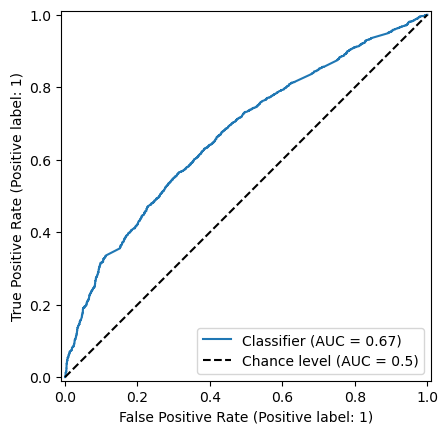

In [38]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_cat_test, y_cat_pred_p_test, plot_chance_level=True);

<Figure size 1000x1000 with 0 Axes>

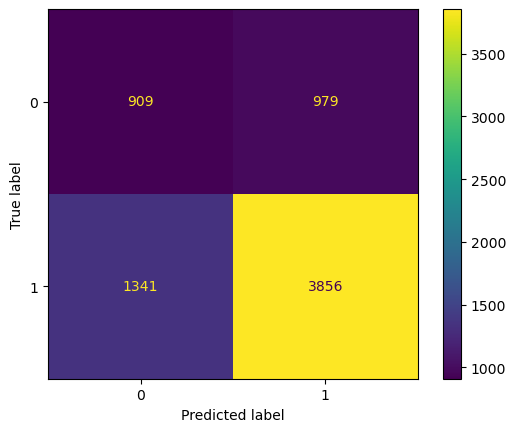

In [39]:
plt.figure(figsize=(10, 10))
metrics.ConfusionMatrixDisplay.from_predictions(y_cat_test, y_cat_pred_test)
plt.grid(False)
plt.show()

First, the ROC AUC gives us a value of 0.67, showing sensibly better performance than a random classifier. Second, the macro-averaged F1-score is 0.61 and the balanced accuracy is 0.68. The main reason between this reserved performance is the difficulty that has the model to identify defeats. Indeed, the specificity is only 0.46! So if we have a game lost, the model classifies as such only 46% of the time. The recall is a bit better with 0.76. The precision is 0.79. It means that if the model classify a game as a win, there is 4 chances over 5 that the prediction is correct. However, when the model classifies a game as a defeat, it is correct only 41% of the time! This is due to the unbalance between the number of wins and defeats among the samples as mentioned previously.



These results can be explain by a lack of data on players to developp a better model, i.e. more factors would be needed to fully understand what makes a player win, such as their age, their origin, their education level, etc. An additional idea would be to analyze how much the start and target articles are already familiar to an average player. The model still identify quite well the games that will be won.

In summary, some particular categories do have an influence on the probability of win. The influence of shortest path is rather small, whereas the one from the number of links to the target is rather important. 

## Part 2 : Wikipedia evolution between 2007 and 2024

### 2.0) Getting our hands on Wikipedia 2024

In this part, we investigate the structural evolution of Wikipedia between 2007 and 2024. To do so, we compare the focus on the links' network of the 4604 articles that were selected in the 2007 Wikispeedia dataset at both time points. The subselection of articles was done by the creators of the game Wikispeedia [1], [2]. 


#### Loading the raw scrapping of Wikipedia 2024

To compare Wikipedia structure between 2007 and 2024 we first had to retrieve the content of the current Wikipedia database. We scrapped the 4604 equivalent articles of Wikispeedia by referring by their names. The details of this step can be found in ```scrapping.ipynb```.


In [40]:
# importing articles names and links
raw_articles2007, raw_links2007 = loading_articles_links('2007', raw = True)
raw_articles2024, raw_links2024 = loading_articles_links('2024', raw = True)

In [41]:
# checking the sizes 
print('Number of articles in 2007 :',len(raw_articles2007)) 
print('Number of articles in 2024 :',len(raw_articles2024))
print('Number of links in 2007 :', raw_links2007.shape[0]) 
print('Number of links in 2024 :',raw_links2024.shape[0])

Number of articles in 2007 : 4604
Number of articles in 2024 : 4592
Number of links in 2007 : 119882
Number of links in 2024 : 225800


Interstingly, by scrapping the corresponding articles, we miss 11 articles. Let us investigate on which articles we are missing these particular articles in 2024 and why did their scrapping  fail.

#### From eleven missing articles to only four

When retrieving 2024 Wikipedia articles, for eleven article names the corresponding URL did not exist anymore in 2024. For seven of them we could find the equivalent page on Wikipedia 2024 with a slightly different name. The corresponding URL to the new page is provided in brakets, along with the new name. However for four of them no evident equivalent page could be found. This leads us to think that these four specific pages have been removed from Wikipedia between 2007 and 2024.

| Article Title | New name (and True Link) |
|---------------|----------|
| Athletics_(track_and_field) | [Track_and_field](https://en.wikipedia.org/wiki/Track_and_field) |
| Bionicle__Mask_of_Light | [Bionicle:_Mask_of_Light](https://en.wikipedia.org/wiki/Bionicle:_Mask_of_Light) |
| Directdebit | [Direct_debit](https://en.wikipedia.org/wiki/Direct_debit) |
| Friend_Directdebit | - |
| Gallery_of_the_Kings_and_Queens_of_England | - |
| Newshounds | [News_Hounds](https://en.wikipedia.org/wiki/News_Hounds) |
| Sponsorship_Directdebit | - |
| Star_Wars_Episode_IV__A_New_Hope | [Star_Wars_(film)](https://en.wikipedia.org/wiki/Star_Wars_(film)) |
| Wikipedia_Text_of_the_GNU_Free_Documentation_License | [Wikipedia:Text_of_the_GNU_Free_Documentation_License](https://en.wikipedia.org/wiki/Wikipedia:Text_of_the_GNU_Free_Documentation_License) |
| Wowpurchase | - |
| X-Men__The_Last_Stand | [X-Men:_The_Last_Stand](https://en.wikipedia.org/wiki/X-Men:_The_Last_Stand) |

We manually added the seven newly named articles back to the dataframe of 2024 articles, by referring to them with their previous name, for comparability.
To investigate a bit more the four missing pages, let us look at their plain text articles, provided by Wikispeedia.

In [42]:
# define path to the data
PLAIN_TEXT_PATH = 'data/2007/plain_text_articles/'

# extract the plain text articles from 2007
Friend_Directdebit = open(os.path.join(PLAIN_TEXT_PATH, 'Friend_Directdebit.txt')).read()
Gallery_of_the_Kings_and_Queens_of_England = open(os.path.join(PLAIN_TEXT_PATH, 'Gallery_of_the_Kings_and_Queens_of_England.txt')).read()
Sponsorship_Directdebit = open(os.path.join(PLAIN_TEXT_PATH, 'Sponsorship_Directdebit.txt')).read()
Wowpurchase = open(os.path.join(PLAIN_TEXT_PATH, 'Wowpurchase.txt')).read()

In [43]:
print(Friend_Directdebit[1:885])

                            [1x1.gif] [1x1.gif]


   [Direct_Debit.gif]

Become an SOS Friend - Direct Debit


   Thank you for taking a moment to complete this simple form, and for
   helping us help orphaned and abandoned children around the world.

   The minimum donation for an SOS friend is £10/month. If you cannot
   afford this, please use this link to making a smaller regular donation.

   All the normal Direct Debit safeguards and guarantees apply. No changes
   in the amount, date or frequency to be debited can be made without
   notifying you at least 10 working days in advance of your accounts
   being debited. In the event of any error, you are entitled to an
   immediate refund from your Bank or Building Society. You have the right
   to cancel a Direct Debit Instruction at any time simply by writing to
   your Bank or Building Society, with a copy to us.

 


In [44]:
print(Gallery_of_the_Kings_and_Queens_of_England[1:580])

  #copyright

Gallery of the Kings and Queens of England

2007 Schools Wikipedia Selection. Related subjects: British History

   This is a gallery of the Kings and Queens of England.

House of Wessex

                         Alfred the Great (871-899)

                         Edward the Elder (899-924)

                               Ælfweard (924)

       Athelstan (924-939)The first de facto King of a unified England

                             Edmund I (939-946)

                               Edred (946-955)

                           Edwy the Fair (955-959)

   


Interestingly, it seems like the three articles DirectDebit, SponsorshipDebit and Wowpurchase are not articles but foundraise forms. We first thought that they were simply removed from Wikipedia because this kind of page does not respect the plateform's policy, but we found out that these three articles are actually [Easter Eggs](https://web.archive.org/web/20071006054112/http://schools-wikipedia.org/) planted by Wikipedia and SOS Children volunteers who heleped implemented the game . Wikispeedia players could thus go to these pages and click on their links if they wanted to even if they are not real articles from Wikipedia. 

Lastly, it is not sure why Gallery_of_the_Kings_and_Queens_of_England was removed from wikipedia, it is probable that this subject was restructured into several pages for each of the royal families, which is why we cannot find an equivalent page in 2024.

For the rest of our study, we will let these four article in 2007 without matching article in 2024. However, we will probably have to remove them from some visualizations when matching dimensions between the two datasets will be needed.

#### Ambiguous pages

When inspecting some imported articles, it was discovered that some of them scrapping succeded meaning the URL exists in 2024, but the page does not contain any link directing to the rest of Wikispeedia articles. We discovered that some of those URLS were reformatted as disambuation pages. The URLs exist but represent Wikipedia pages proposing a list of equivalent ambiguous names (eg: https://en.wikipedia.org/wiki/Battle_of_Amiens). We therefore found all pages that we suspected to be disambuguation pages and manually found there new names based on the content of the 2007's pages.

In [45]:
# importing articles names and links
articles2007, links2007 = loading_articles_links('2007')
articles2024, links2024 = loading_articles_links('2024')

DATA_2007_PATH = 'data/2007/'
articles2007 = pd.read_csv(os.path.join(DATA_2007_PATH , 'articles.tsv'), sep='\t', comment='#', names=['article_2007'])
links2007 = pd.read_csv(os.path.join(DATA_2007_PATH, 'links.tsv'), sep='\t', comment='#', names=['linkSource', 'linkTarget'] )
DATA_2024_PATH = 'data/2024/'
articles2024 = pd.read_csv(os.path.join(DATA_2024_PATH, 'ambig_articles2024.csv'), sep='\t', comment='#', names=['article_2024']) # TODO: seems like articles2024.article_2024 still contains the new names for x-men:_the_last_stand and maybe other articles >:()
links2024 = pd.read_csv(os.path.join(DATA_2024_PATH, 'ambig_links2024.csv'), skiprows=1, names=['linkSource', 'linkTarget'])

In [46]:
source_articles2007 = set(links2007.linkSource.drop_duplicates().reset_index(drop = True))
source_articles2024 = set(links2024.linkSource.drop_duplicates().reset_index(drop = True))

print(f"In 2007, we find {len(source_articles2007)} articles that contain at least one link.")
print(f"In 2024, we find {len(source_articles2024)} articles that contain at least one link.")

In 2007, we find 4587 articles that contain at least one link.
In 2024, we find 4552 articles that contain at least one link.


In [47]:
empty_source_2007 = set(articles2007.article_2007) - source_articles2007
empty_source_2024 = set(articles2007.article_2007) - source_articles2024 #TODO seems like articles2024.article_2024 still contains the new names for x-men:_the_last_stand and maybe other articles >:()

print(f"In 2007, {len(empty_source_2007)} contain no links.")
print(f"In 2024, {len(empty_source_2024)} contain no links.")

In 2007, 17 contain no links.
In 2024, 53 contain no links.


In [48]:
print(empty_source_2007)
print(empty_source_2024)

{'Lone_Wolf_%28gamebooks%29', 'Underground_%28stories%29', 'Directdebit', 'Local_community', 'Color_Graphics_Adapter', 'Douglas_DC-4', 'Vacutainer', 'Wowpurchase', 'Osteomalacia', 'Klinefelter%27s_syndrome', 'Donation', 'Suikinkutsu', 'Schatzki_ring', 'Duchenne_muscular_dystrophy', 'Wikipedia_Text_of_the_GNU_Free_Documentation_License', 'Private_Peaceful', 'Badugi'}
{'Underground_%28stories%29', 'Forth', 'Lost_%28TV_series%29', 'Bj%C3%B8rn%C3%B8ya', 'Firecrest', 'Dark_Ages', 'Suikinkutsu', 'Garage_%28dance_music%29', 'Doom', 'Anne_of_Great_Britain', 'Tripoli', 'Recorder', 'Terik', 'Industry', 'Prehistoric_man', 'Whitethroat', 'Red_Panda', 'Winfield_Scott_%28ship%29', 'Sandur', 'Friend_Directdebit', 'Lake_Albert', 'Zulu', 'Serenity_%28film%29', 'Sponsorship_Directdebit', 'Nagorno-Karabakh_War', 'Pochard', 'Sequoia', 'Scent_of_a_Woman', 'Market', 'David_Heymann', 'Wowpurchase', 'Marc_Pugh', 'Badugi', 'Brabantian', 'William_Gilbert', 'Bantu', 'Mark_Webber', 'Wikipedia_Text_of_the_GNU_Free

In [49]:
# Let us select all articles that contain links in one year but none in the other year:
not_in_2007 = source_articles2024 - source_articles2007
not_in_2024 = source_articles2007 - source_articles2024

print(len(not_in_2007), not_in_2007)
print(len(not_in_2024), not_in_2024)

13 {'Lone_Wolf_%28gamebooks%29', 'Directdebit', 'linkSource', 'Local_community', 'Color_Graphics_Adapter', 'Douglas_DC-4', 'Vacutainer', 'Osteomalacia', 'Donation', 'Klinefelter%27s_syndrome', 'Schatzki_ring', 'Duchenne_muscular_dystrophy', 'Private_Peaceful'}
48 {'Forth', 'Lost_%28TV_series%29', 'Bj%C3%B8rn%C3%B8ya', 'Firecrest', 'Dark_Ages', 'Doom', 'Garage_%28dance_music%29', 'Anne_of_Great_Britain', 'Tripoli', 'Recorder', 'Terik', 'Industry', 'Prehistoric_man', 'Whitethroat', 'Red_Panda', 'Winfield_Scott_%28ship%29', 'Sandur', 'Friend_Directdebit', 'Lake_Albert', 'Zulu', 'Serenity_%28film%29', 'Sponsorship_Directdebit', 'Nagorno-Karabakh_War', 'Pochard', 'Sequoia', 'Scent_of_a_Woman', 'Market', 'David_Heymann', 'Marc_Pugh', 'Brabantian', 'William_Gilbert', 'Bantu', 'Mark_Webber', 'Blackbird', 'Weymouth', 'Boa', 'Tooth_development', 'Battle_of_Amiens', 'Herring_Gull', 'Newmarket', 'Defaka', 'Boston_RFC', 'Swift', 'Aggregator', 'Gallery_of_the_Kings_and_Queens_of_England', 'Sparrowha

### Articles that contain no links in 2007 but not in 2024


We could find 12 articles that were dead-ends articles in 2007 and are not anymore nowadays. Could those articles be more interesting and useful for players if they were to play in 2024? How many times were these pages visited by players in 2007 when searching for their target, forcing them to go back to the previsou article?

- Color_Graphics_Adapter
- Directdebit
- Donation
- Douglas_DC-4
- Duchenne_muscular_dystrophy
- Klinefelter%27s_syndrome
- Local_community
- Lone_Wolf_%28gamebooks%29
- Private_Peaceful
- Osteomalacia
- Schatzki_ring
- Vacutainer

### Articles that contain no links in 2024 but not in 2007 

| **Old Title**                           | **Status $\star$** | **New Title**                      | **Link**                                                  |
|-----------------------------------------|--------------------|-------------------------------------|----------------------------------------------------------|
| Aggregator                              | A                  | News_aggregator                    | https://en.wikipedia.org/wiki/News_aggregator           |
| Anne_of_Great_Britain                   | A                  | Anne,_Queen_of_Great_Britain       | https://en.wikipedia.org/wiki/Anne,_Queen_of_Great_Britain |
| Bantu                                   | A                  | Bantu_peoples                      | https://en.wikipedia.org/wiki/Bantu_peoples             |
| Battle_of_Amiens                        | A                  | Battle_of_Amiens_(1918)            | https://en.wikipedia.org/wiki/Battle_of_Amiens_(1918)   |
| Blackbird                               | A                  | Common_blackbird                   | https://en.wikipedia.org/wiki/Common_blackbird          |
| Bj%C3%B8rn%C3%B8ya                      | A                  | Bear_Island_(Svalbard)             | https://en.wikipedia.org/wiki/Bear_Island_(Svalbard)    |
| Boa                                     | A                  | Boa_(genus)                        | https://en.wikipedia.org/wiki/Boa_(genus)               |
| Boston_RFC                              | A                  | Boston_RFC_(United_States)         | https://en.wikipedia.org/wiki/Boston_RFC_(United_States) |
| Brabantian                              | A                  | Brabantian_Dutch                   | https://en.wikipedia.org/wiki/Brabantian_Dutch          |
| Dark_Ages                               | A                  | Dark_Ages_(historiography)         | https://en.wikipedia.org/wiki/Dark_Ages_(historiography)|
| David_Heymann                           | A                  | David_Heymann_(architect)          | https://en.wikipedia.org/wiki/David_Heymann_(architect) |
| Defaka                                  | A                  | Defaka_people                      | https://en.wikipedia.org/wiki/Defaka_people             |
| Doom                                    | A                  | Doom_(1993_video_game)             | https://en.wikipedia.org/wiki/Doom_(1993_video_game)    |
| Firecrest                               | A                  | Common_firecrest                   | https://en.wikipedia.org/wiki/Common_firecrest          |
| Forth                                   | A                  | Forth_(programming_language)       | https://en.wikipedia.org/wiki/Forth_(programming_language) |
| Friend_Directdebit                      | D                  | -                                  | -                                                        |
| Gallery_of_the_Kings_and_Queens_of_England | D               | -                                  | -                                                        |
| Garage_%28dance_music%29                | A                  | Garage_house                       | https://en.wikipedia.org/wiki/Garage_house              |
| Herring_Gull                            | A                  | American_herring_gull              | https://en.wikipedia.org/wiki/American_herring_gull     |
| Industry                                | A                  | Industry_(economics)               | https://en.wikipedia.org/wiki/Industry_(economics)      |
| Lake_Albert                             | A                  | Lake_Albert_(Africa)               | https://en.wikipedia.org/wiki/Lake_Albert_(Africa)      |
| Lost_%28TV_series%29                    | X                  | Lost_(TV_series)                   | https://en.wikipedia.org/wiki/Lost_%28TV_series%29      |
| Margin_of_error                         | X                  | Margin_of_error                    | https://en.wikipedia.org/wiki/Margin_of_error           |
| Marc_Pugh                               | X                  | Marc_Pugh                          | https://en.wikipedia.org/wiki/Marc_Pugh                 |
| Mark_Webber                             | A                  | Mark_Webber_(racing_driver)        | https://en.wikipedia.org/wiki/Mark_Webber_(racing_driver) |
| Market                                  | A                  | Market_(economics)                 | https://en.wikipedia.org/wiki/Market_(economics)        |
| Nagorno-Karabakh_War                    | A                  | First_Nagorno-Karabakh_War         | https://en.wikipedia.org/wiki/First_Nagorno-Karabakh_War |
| Newmarket                               | A                  | Newmarket,_Suffolk                 | https://en.wikipedia.org/wiki/Newmarket,_Suffolk        |
| Pochard                                 | A                  | Common_pochard                     | https://en.wikipedia.org/wiki/Common_pochard            |
| Prehistoric_man                         | A                  | Prehistory                         | https://en.wikipedia.org/wiki/Prehistory                |
| Recorder                                | A                  | Recorder_(musical_instrument)      | https://en.wikipedia.org/wiki/Recorder_(musical_instrument)|
| Red_Panda                               | A                  | Red_panda                          | https://en.wikipedia.org/wiki/Red_panda                 |
| Sandur                                  | A                  | Outwash_plain                      | https://en.wikipedia.org/wiki/Outwash_plain             |
| Scent_of_a_Woman                        | A                  | Scent_of_a_Woman_(1992_film)       | https://en.wikipedia.org/wiki/Scent_of_a_Woman_(1992_film)|
| Sequoia                                 | A                  | Sequoia_(genus)                    | https://en.wikipedia.org/wiki/Sequoia_(genus)           |
| Serenity_%28film%29                     | A                  | Serenity_(2005_film)               | https://en.wikipedia.org/wiki/Serenity_(2005_film)      |
| Sparrowhawk                             | I                  | Eurasian_sparrowhawk               | https://en.wikipedia.org/wiki/Eurasian_sparrowhawk      |
| Sponsorship_Directdebit                 | D                  | -                                  | -                                                        |
| Swift                                   | A                  | Swift_(bird)                       | https://en.wikipedia.org/wiki/Swift_(bird)              |
| Terik                                   | R                  | Terik_people                       | https://en.wikipedia.org/wiki/Terik_people              |
| Tooth_development                       | A                  | Human_tooth_development            | https://en.wikipedia.org/wiki/Human_tooth_development   |
| Tripoli                                 | A                  | Tripoli,_Libya                     | https://en.wikipedia.org/wiki/Tripoli,_Libya            |
| Weymouth                                | A                  | Weymouth,_Dorset                   | https://en.wikipedia.org/wiki/Weymouth,_Dorset          |
| Whitethroat                             | A                  | Common_whitethroat                 | https://en.wikipedia.org/wiki/Common_whitethroat        |
| William_Gilbert                         | A                  | William_Gilbert_(physicist)        | https://en.wikipedia.org/wiki/William_Gilbert_(physicist)|
| Winfield_Scott_%28ship%29               | A                  | SS_Winfield_Scott                  | https://en.wikipedia.org/wiki/SS_Winfield_Scott         |
| Woodruff                                | A                  | Galium_odoratum                    | https://en.wikipedia.org/wiki/Galium_odoratum           |
| Zulu                                    | A                  | Zulu_people                        | https://en.wikipedia.org/wiki/Zulu_people               |

$\star$ Status column legend:
* A is for URLs that became disambiguation page
* X for already corresponding pages (title unchanged since 2007)
* D for pages that disappeared since 2007
* R for remaining urls from 2007 that redirects to the correct new link
* I for pages that became an index of subcategories of the initial article.

In [50]:
# Articles that have no links in both years
forever_empty = empty_source_2024 - not_in_2007 - not_in_2024
print(forever_empty)

{'Underground_%28stories%29', 'Wowpurchase', 'Suikinkutsu', 'Wikipedia_Text_of_the_GNU_Free_Documentation_License', 'Badugi'}


| **Old Title**                           | **Status $\star$** | **New Title**                      | **Link**                                                  |
|-----------------------------------------|--------------------|-------------------------------------|----------------------------------------------------------|
| Badugi | X  | Badugi  | https://en.wikipedia.org/wiki/Badugi  |
| Suikinkutsu   | X   | Suikinkutsu  | https://en.wikipedia.org/wiki/Suikinkutsu |
| Underground_%28stories%29 | R  | Underground_(Murakami_book)  | https://en.wikipedia.org/wiki/Underground_(Murakami_book)  |
| Wikipedia_Text_of_the_GNU_Free_Documentation_License  | C  | Wikipedia:Text_of_the_GNU_Free_Documentation_License | https://en.wikipedia.org/wiki/Wikipedia:Text_of_the_GNU_Free_Documentation_License   |
| Wowpurchase  | D  | -  | -          |

 $\star$ Status column legend:
* X for already corresponding pages (title unchanged since 2007)
* C for pages that changed title since 2007
* D for pages that disappeared since 2007
* R for remaining urls from 2007 that redirects to the correct new link

#### To summarize: 

- Among the ```48 articles``` that did not contain any link in 2024 but not in 2007:
  - ```40 A```: 40 of them became ambiguous. Their initial URLs thus became disambiguation pages in which often was mentionned the equivalent page from 2007. We were able to manually retrieve the changed titles.
  - ```3 X```: 3 of them did not become ambiguous pages and were actually already corresponding to the initial article. They were correctly labeled as containing no link. We do not need to change their title to scrap them.
  - ```3 D```: 3 of them disappeared since 2007. They correspond to three of the missing pages we already identified earlier in the analysis.
  - ```1 R```: 1 of them became an URL that do not contain any article but is supposed to redirect users to the correct new link. We were able to take the new title of the page it normally redirects to scrap it correctly.
  - ```1 I```: 1 of them became an index page for subcategories of the initial article. We were able to take the new title of the page it normally redirects to scrap it correctly.

- Among the ```5 articles``` that did not contain any links in both years:
  - ```2 X```: 2 of them did not become ambiguous pages and were actually already corresponding to the initial article. They were correctly labeled as containing no link. We do not need to change their title to scrap them.
  - ```1 R```: 1 of them became an URL that do not contain any article but is supposed to redirect users to the correct new link. We were able to take the new title of the page it normally redirects to scrap it correctly.
  - ```1 C```: 1 of them changed title since 2007. We already noticed that change and already had the scrap the new equivalent page but still no link were found in 2024. It was correctly labeled as empty.
  - ```1 D```: 1 of them disappeared. It corresponds to the last missing page we already identified earlier in the analysis.

We thus had to re-scrap all ```A```, ```R``` and ```I``` articles with their updated disambiguated names. We consider that we were able to identify all articles present in 2007 that we missed when importing their equivalent of 2024 because of a name change. In ```scrapping.ipynb``` we rescrapped all 2024 articles's links with all articles that disappeared or changed names since 2007. From now on, we will use this new dataset for the rest of our analysis.

### 2.1) Loading the clean data

In [51]:
# importing articles names and links
articles2007, links2007 = loading_articles_links('2007')
articles2024, links2024 = loading_articles_links('2024')

We now would like to take a look at the links we imported. Some source articles had no targets in 2007 but do have new targets in 2024. The other way around is also possible: 2007 target articles may have change so drasticly that no link exist anymore in 2024. We will thus look at the articles that are not present as source articles in 2007 vs in 2024.

In [52]:
source_articles2007 = set(links2007.linkSource.drop_duplicates().reset_index(drop = True))
source_articles2024 = set(links2024.linkSource.drop_duplicates().reset_index(drop = True))

print(len(source_articles2007), len(source_articles2024))

4587 4594


In [53]:
not_in_2007 = source_articles2024 - source_articles2007
not_in_2024 = source_articles2007 - source_articles2024

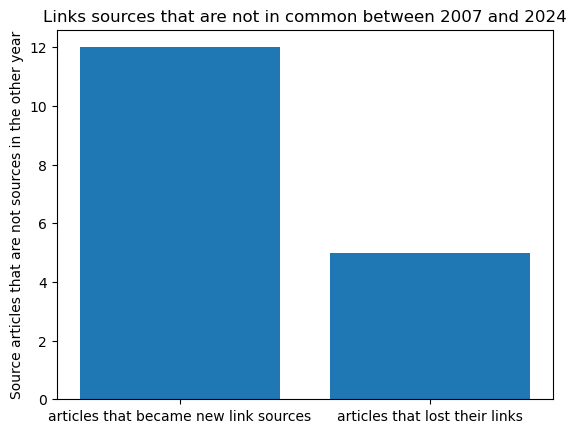

In [54]:
plt.bar(x=['articles that became new link sources','articles that lost their links'], height=[len(not_in_2007), len(not_in_2024)])
plt.title('Links sources that are not in common between 2007 and 2024')
plt.ylabel("Source articles that are not sources in the other year")
plt.show()

After rescrapping we are left with the following difference:
- 12 articles had no links in 2007 but now have links in 2024
- 5 articles had links in 2007 but do not have any link anymore in 2024

In [55]:
# checking the sizes 
print('2007 :',len(articles2007),'articles,', len(links2007),'links') 
print('2024 :',len(articles2024),'articles,', len(links2024),'links')

2007 : 4604 articles, 119882 links
2024 : 4600 articles, 225800 links


As mentionned above in part 0, some articles have been deleted between 2007 and 2024. So the list of articles of 2024 does not contain them and there are no links redirecting to them in the links2024 file. However we retrieved the articles whose names have been modified and kept the name for 2007 to refer to them in the 2024 list. 

### 2.2) Comparing the Hyperlinks Structure 

As a first analysis to justify our project we compare the two wikipedia version structures. 

T test p value : [3.27970061e-190]


/opt/anaconda3/envs/outlier/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3643: FutureWarning:

The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



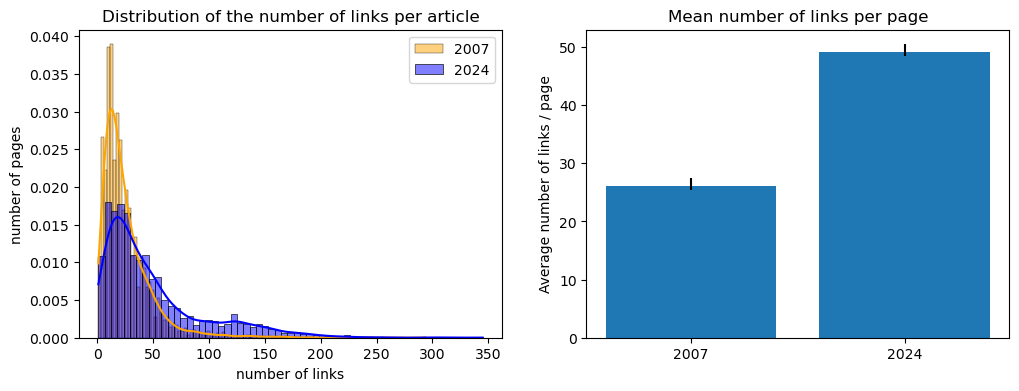

In [56]:
plot_average_links_per_page(links2007, links2024, articles2007, graph_based=False)

The two distributions seem different, as already observed. In global there are more links per pages on average in 2024 than in 2007, as this is confirmed by our independent T test p value of 6.9e-191, this difference is statistically significative. When looking a the distributions we also see that the 2024 one has more articles with a higher number of links and also less articles with a small number of links. 

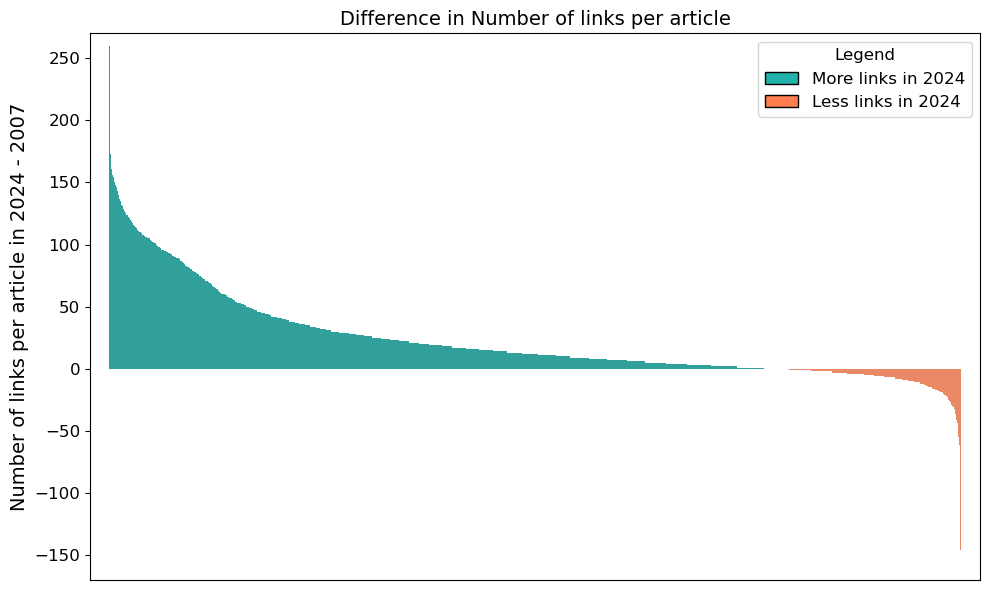

In [57]:
plot_difference_links_article(links2007, links2024)

Here we look more closely at each article, to see how the number of links per page evolved. Everything above zero represent a positive difference between the number of links in 2024 minus the number in 2007 so this relates to when 2024 has more links than 2007, and everything below will thus correspond to 2024 having less links than in 2007. Visually we can already see that there tends to be more links in 2024 than in 2007 for the same article. 

### 2.3) Networks comparison

As a metric to how connected the two wikipedia are, we also look into the shortest path matrix for the both of them and other network metrics. The Shortest Paths are computed using the Floyd Warshall algorithms. We verified that the function used, from the networkx package, produced the exact same matrix for the 2007 data in the exploratory notebook. 

In [58]:
### creating Graphs 
G_2007 = creating_graph(links2007, articles2007)
G_2024 = creating_graph(links2024, articles2007)
# here we use the list of articles from 2007 as it has all the nodes
# whereas some are missing in the 2024 list as stated earlier 
# it is important to create all the nodes even if we don't have any link 
# that connects them to the other, in order to generate the difference map later
# so that the two spm have the same dimensions

As the computation of the shortest path matrices are very time-intensive, we have saved the results from the computation in a zipped file within `/data/spm.zip`. 

In [59]:
#### UNCOMMENT THIS CELL TO COMPUTE THE SPM AGAIN

# ### computing shortest path matrices (spm)
# # WARNING : this step takes approx 15 min
# spm_2007 = computing_shortest_path_matrix(G_2007, articles2007)
# spm_2024 = computing_shortest_path_matrix(G_2024, articles2007)

In [60]:
# Load Zipped Saved matrices :
spm_2007, spm_2024 = loading_zipped_spm()

#### Control Graphs 

As a way to compare our networks performances and connectivity we create 2 random graphs that will be used as reference points for comparison. The graphs are created with the same number of edges and nodes as the graphs they are supposed to be compared to. 

In [61]:
### Creating random graphs as a control
N = len(articles2007)  # same number of nodes
E_2007 = len(links2007)  # same number of edges for the 2007 control graph
E_2024 = len(links2024) # same for the 2024 control

# We fix the seeds to be able to save the results for reproducibility
control_2007 = nx.gnm_random_graph(N, E_2007, seed=2007, directed=True)
control_2024 = nx.gnm_random_graph(N, E_2024, seed=2024, directed=True)

Similarly to our Wikipedia graphs, we need to compute the shortest path average and thus the SPM too.

In [62]:
### UNCOMMENT THIS CELL TO RECOMPUTE THE SHORTEST PATH MATRICES
# # WARNING : this step take approx 17 min
# control_spm_2007 = nx.floyd_warshall_numpy(control_2007)
# control_spm_2024 = nx.floyd_warshall_numpy(control_2024)

In [63]:
# Loading Zipped Control SPMs :
control_spm_2007, control_spm_2024 = loading_zipped_spm(control=True)

In [64]:
# np.savetxt("control2007.csv", control_spm_2007, delimiter=",")
# np.savetxt("control2024.csv", control_spm_2024, delimiter=",")

#### Average Shortest Path 

First lets us look into a basic comparison of the two networks, how is the shortest path on average for the two years ? 

In [65]:
reachable_spm_2007 = [x if x != np.inf else 0 for row in spm_2007 for x in row ]
reachable_spm_2024 = [x if x != np.inf else 0 for row in spm_2024 for x in row ]

reachable_control_2007 = [x if x!= np.inf else 0 for row in control_spm_2007 for x in row]
reachable_control_2024 = [x if x!= np.inf else 0 for row in control_spm_2024 for x in row]

average_spm = pd.DataFrame(index=['Average Shortest Path for reachable pairs', 
                                  'Control Graphs', 'T test P value'])
average_spm['2007'] = [np.sum(reachable_spm_2007)/len(reachable_spm_2007), 
                       np.sum(reachable_control_2007)/len(reachable_control_2007),
                       ttest_ind(reachable_control_2007, reachable_spm_2007)[1]]
average_spm['2024'] = [np.sum(reachable_spm_2024)/len(reachable_spm_2024),
                       np.sum(reachable_control_2024)/len(reachable_control_2024),
                       ttest_ind(reachable_control_2024, reachable_spm_2024)[1]]
average_spm['T test p value'] = [ttest_ind(reachable_spm_2007, reachable_spm_2024)[1],
                                 ttest_ind(reachable_control_2007, reachable_control_2024)[1],
                                 '-']
average_spm

,2007,2024,T test p value
Average Shortest Path for reachable pairs,2.808365,2.452919,0.0
Control Graphs,2.882139,2.575679,0.0
T test P value,0.000000,0.000000,-


The control graphs have a similar average shortest path to their respective Wikipedia graphs, however the small difference is statistically significant too.

We observe that the shortest path is on average statistically significantly slightly shorter in 2024 than in 2007. This could reflect the increased number of links in 2024 and thus may improve the navigability of the 2024 network. As we saw previously, there exist a link between the shortest path and the success of the path so having a shorter average shortest path should help the players.  

#### Average Clustering Coefficient :

Clustering coefficient is a measure of how well nodes in a graph tend to cluster together.

In [66]:
clustering = pd.DataFrame(index=['average clustering', 'random clustering'])
clustering['2007'] = [nx.average_clustering(G_2007), nx.average_clustering(control_2007)]
clustering['2024'] = [nx.average_clustering(G_2024), nx.average_clustering(control_2024)]

clustering

,2007,2024
average clustering,0.194941,0.262108
random clustering,0.005573,0.010628


Looking at the clustering coefficients and the average shortest paths, we can determine wheter our two graphs are small world networks. For a graph to represent a small world network, it needs to have a similar average shortest path to an equivalent and similarly sized random graph but with a higher clustering coefficient. Here we can say that both 2007 and 2024 Wikipedias are small world network. 

#### Comparing Shortest Path Matrices 

To compare further the shortest path matrices of the two years we create the following heatmaps. 
To visualize the differences in shortest path, we substract the Shortest Path Matrix of 2024 minus the one of 2007 for the same source to the same target. This way any point corresponding to a positive value means the path from the two articles is shorter in 2024, while a negative value means the path in 2024 is longer than in 2007

In [ ]:
### PLOTLY VERSION : 
# interactive but too heavy to be pushed on github

fig = plotting_difference_heatmap_plotly(spm_2007, spm_2024)
fig.show() 

# # # Saving to htlm 
# plotly_save_to_html(fig , 'heatmap_difference')

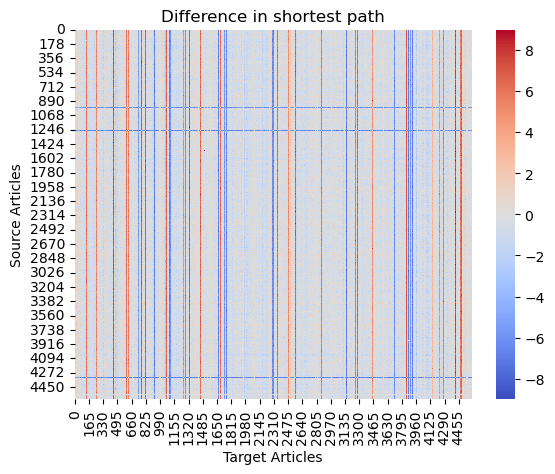

In [68]:
### SEABORN VERSION : 
# less easy to read but less heavy
# both heatmaps present the same information

plotting_difference_heatmap_sns(spm_2007,spm_2024)

For most of the matrix we see almost no difference, as the heatmap is mostly close to 0. It tends to look a little red-ish but it is difficult to assume anything from looking at this graph. However we do see that some lines of red or blue appear, meaning there are some articles that have on average either a longer or shorter shortest path with every article in the database. 

#### Strongly Connected Components 

Now we look into the strongly connected components (scc) of the graphs. This refers to subparts of the graph that have a good connectivity between them, meaning you can go from any node within a scc to any other node of the same scc. 

In [69]:
# computing SCC and their overall shortest path across SCC 
# WARNING : this step may take up to 12 min
print('2007 :')
scc_2007, overall_avg_2007, avg_lengths_2007 = computing_scc_avg(G_2007)

print('2024 :')
scc_2024, overall_avg_2024, avg_lengths_2024 = computing_scc_avg(G_2024)

2007 :
Overall Average Shortest Path Length (across SCCs) : 1.1148
2024 :
Overall Average Shortest Path Length (across SCCs) : 1.3110


In [70]:
ttest_ind(avg_lengths_2007, avg_lengths_2024)

TtestResult(statistic=2.7073056511540643, pvalue=0.006878056218233279, df=1218.0)

Both Overall Shortest Path Averages are very similar, even though the p value is statistically significant the difference between the two remains very small. 

In [71]:
data_scc = pd.DataFrame(index=['number of nodes within the biggest SCC', 
                               'number of SCCs of average shortest path length = 1 ',
                               'number of SCC of size > 1',
                           'number of articles not in a SCC', 
                           'Overall Average Shortest Path across SCC'])

data_scc['2007'] = [max([len(scc) for scc in scc_2007 if len(scc)> 1]),
                    sum([1 for scc_avg in avg_lengths_2007 if scc_avg == 1]),
                    sum([False if len(scc)==1 else True for scc in scc_2007]),
                    sum([True if len(scc)==1 else False for scc in scc_2007]),
                    overall_avg_2007]
data_scc['2024'] = [max([len(scc) for scc in scc_2024 if len(scc)> 1]),
                    sum([1 for scc_avg in avg_lengths_2024 if scc_avg == 1]),
                    sum([False if len(scc)==1 else True for scc in scc_2024]),
                    sum([True if len(scc)==1 else False for scc in scc_2024]),
                    overall_avg_2024]

data_scc

,2007,2024
number of nodes within the biggest SCC,4051.000000,3910.000000
number of SCCs of average shortest path length = 1,18.000000,5.000000
number of SCC of size > 1,19.000000,6.000000
number of articles not in a SCC,512.000000,683.000000
Overall Average Shortest Path across SCC,1.114805,1.311016


We see that for both networks, they only contain 1 big SCC. Most of the other SCCs contain only 2 articles. The rest of the articles do not fit within any SCC, but the number of articles contained within one SCCs is different in both cases : 
- in 2007 the big SCC contains 4051 articles, and there are 18 SCCs of size 2
- in 2024 the big SCC contains 3910 articles, and there are 5 SCCs of size 2

It is difficult to draw any conclusions from that as the two networks thus have a similar structure, even though less articles are strongly connected in 2024. Let's dive further into the detail of the two networks structures. 

#### Pagerank Centrality

To assess the differences between the two networks we will use the pagerank centrality measurement. This measure is adapted to very sparse and large networks as we have here, and represent how 'important' a node is by how many inlinks redirect to it from other central nodes. 

The pagerank centrality $x_i$ is computed as follows : 
$$ x_i = \sum_j a_{ji} \frac{x_j}{\sum_{j} a_{ji}} $$
with $a_{ji}$ entry (j,i) of adjacency matrix $A$

This measure will allow us to look into which articles are considered more 'central' in 2007 versus 2024. Below are the top 0.5% pagerank centrality articles plotted for better visualisation purposes. 

In [72]:
fig = plot_pagerank(G_2007, year='2007')
fig.show()

# # Saving to htlm 
# plotly_save_to_html(fig , 'pagerank2007')

In [73]:
fig = plot_pagerank(G_2024, year='2024')
fig.show() 

# # Saving to htlm 
# plotly_save_to_html(fig , 'pagerank2024')

We see here that we go from the node 'United_states' being very central and overshadowing the other nodes by far to a more balanced centrality distribution in 2024. The top pagerank node here is now 'World_War_II' that reaches a pagerank of 0.0038. The top node in 2024 is thus less central than the top node in 2007 (where the pagerank of 'United states was 0.0096). 

In [74]:
pagerank_2007 = nx.pagerank(G_2007)
pagerank_2024 = nx.pagerank(G_2024)

In [75]:
# [[key, pagerank_2007[key]] for key in sorted_pr_2007]
sorted_pr_2007 = sorted(pagerank_2007, key = pagerank_2007.get, reverse=True)
sorted_pr_2024 = sorted(pagerank_2024, key = pagerank_2024.get, reverse=True)

pagerank_comparison = pd.DataFrame()
pagerank_comparison['Top20_2007'] = sorted_pr_2007[0:20]
pagerank_comparison['Top20_2024'] = sorted_pr_2024[0:20]

pagerank_comparison

,Top20_2007,Top20_2024
0,United_States,World_War_II
1,France,United_States
2,Europe,United_Kingdom
3,United_Kingdom,Latin
4,English_language,Wikisource
5,Germany,France
6,World_War_II,India
7,England,World_War_I
8,Latin,China
9,India,Canada


T test p value : 1.0


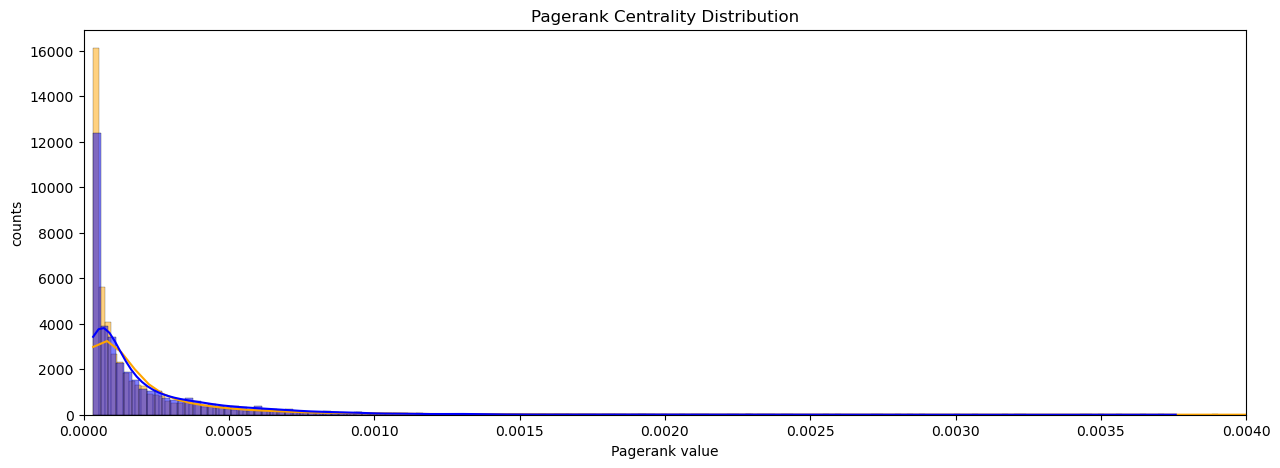

In [76]:
plot_pagerank_distribution(pagerank_2007, pagerank_2024)

TtestResult, pvalue = ttest_ind([pagerank_2007[key] for key in sorted_pr_2007], 
                                [pagerank_2024[key] for key in sorted_pr_2024])
print('T test p value :', pvalue)

We also observe that the top 20 pagerank nodes are mostly countries in both years, with few articles related to other very broad topics such as 'Christianity' or 'Latin'. 

#### Average Node Degree

As a final analysis on our networks, we look at the average node degrees for both graphs.

In [77]:
# Average node degree for directed graphs 

k_2007 = G_2007.number_of_edges() / G_2007.number_of_nodes()
k_2024 = G_2024.number_of_edges() / G_2024.number_of_nodes()

print('average node degree :')
print('2007 :', k_2007)
print('2024 :', k_2024)

average node degree :
2007 : 26.03866203301477
2024 : 49.04430929626412


Looking at the average node degrees, we see that in 2024 we have on average around 2x more nodes connected to an article than in 2007.

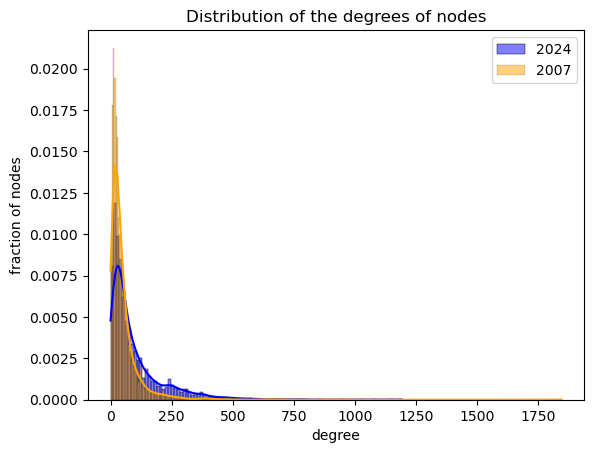

In [78]:
plot_degree_distribution(G_2007, G_2024)

We plot again the distribution of the number of articles connected to one article, which is the same as the degree of a node. The difference with the previous graph resides in the fact that this time we use a graph based approach. This means that we take into account the nodes isolated, i. e. that do not have any link redirecting to another page, in our frequency computation. The resulting distributions have the same tendencies as before but the y axis scale is different. We consider this approach to be more accurate to represent the number of links per pages as using the list of links only does not consider the isolated nodes. 

Finally we look at the average number of reachable nodes. We see that for 2024 the average maximum number of nodes that can be reached is reached sooner in number of hops, compared to 2007. However the maximum number of reachable nodes is also smaller in 2024 than in 2007. This difference is explainable and is probably caused by the deleted articles that we mentionned that can never be reached or other articles changing names that we may have not detected in our scrapping process mentionned in part 2.0. This can also be caused by the articles completely losing their links due to our restricted database that can only contain at most 4604 links from the selected 4604 articles. 

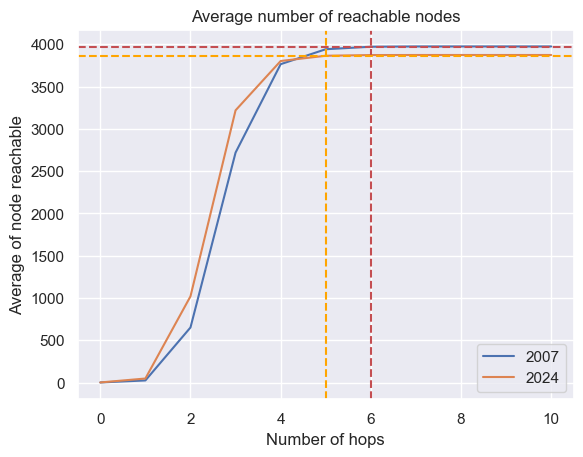

In [79]:
plot_distribution_path_length(G_2007,G_2024)

### 2.4) Conclusion on Wikipedia structural difference 

As we saw, many differences exist between the 2 networks, but it is hard to conclude wheter this would render a 2024 version of the Wikispeedia game easier to play or not. Our intuition is that it should be the case, as on average the shortest path is smaller and the number of links per pages is bigger in 2024. Moreover as we just saw, the number of hops needed to reach the average numbe of nodes is smaller too. However we still cannot infer based on this that the game would be easier for the players, and will thus see how the differences in structure that we studied could impact the paths played in 2007. 

## Part 3 : Would players be better now ?

### Player Path Analysis

#### Path unfinished

Let's determine whether an unfinished path in 2007 could have been completed back then (i.e., if the player was close to reaching the target) and compare it to the 2024 Wikipedia link structure to assess if the player could now finish the game more quickly in 2024 than in 2007.

In [80]:
links2007 = pd.read_csv(os.path.join(PATH_2007, 'links.tsv'), sep='\t', comment='#', names=['linkSource', 'linkTarget'])
links2024 = pd.read_csv(os.path.join(PATH_2024, 'links2024.csv'), comment='#', names=['linkSource', 'linkTarget'])
path_unfinished = pd.read_csv(os.path.join(PATH_2007, 'paths_unfinished.tsv'), sep='\t', comment='#', names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'target', 'type'], usecols=['hashedIpAddress', 'durationInSec', 'path', 'target', 'type'])

In [81]:
# remove path with only one element -> not considered as an attempt
# get path length
path_unfinished['path_length'] = path_unfinished['path'].apply(lambda x: len(x.split(';')))
path_unfinished = path_unfinished[path_unfinished['path_length'] > 3]
path_unfinished.head()

,hashedIpAddress,durationInSec,path,target,type,path_length
5,131600803df4895e,2009,Agriculture;History_of_the_world;China;Yangtze...,Grand_Canal_of_China,timeout,4
6,486bb79910fe9dd2,1932,Mind;Christianity;Europe;Renaissance;Ancient_G...,Scouting,timeout,7
7,6d136e371e42474f,175,4-2-0;United_States;Agriculture;Sugar;Australia,Cane_Toad,restart,5
9,6d136e371e42474f,2006,Logic;Computer_science;Science;Physical_scienc...,Moon_landing,timeout,9
10,430ca00e7f5303b7,1976,Battle_of_Gettysburg;Washington%2C_D.C.;United...,Ostrich,timeout,7


In [82]:
path_unfinished.describe()['path_length']

count    13273.000000
mean         8.147367
std          6.571635
min          4.000000
25%          5.000000
50%          6.000000
75%          9.000000
max        235.000000
Name: path_length, dtype: float64

Let's process our unfinished path to determine whether, theoretically, a player could have completed the game in 2007 and to analyze whether finishing the game is faster in 2024 compared to 2007.

Data format:
| path | target | final_link | distance |
|------|--------|------------|----------|
|path of the player      |   target to reach     |      final link reached before going to target (same as path if target cannot be reached)      |     number of click earned (equal -1 if the path is not possible based on our data)    |

In [83]:
df_unfinished = create_comparison_unfinished_path(DATA, path_unfinished, links2007, links2024, load=True)
print(df_unfinished.shape)
df_unfinished.head()

(19661, 6)


,path,target,final_link2007,final_link2024,distance2007,distance2024
0,Malawi;Democracy;Alexander_the_Great,First_Crusade,Alexander_the_Great,Alexander_the_Great,0,0
1,Paraguay;Bolivia,Mount_St._Helens,Bolivia,Bolivia,0,0
2,Agriculture;History_of_the_world;China;Yangtze...,Grand_Canal_of_China,Yangtze_River,NaN,0,-1
3,Mind;Christianity;Europe;Renaissance;Ancient_G...,Scouting,Asia,Asia,0,0
4,4-2-0;United_States;Agriculture;Sugar;Australia,Cane_Toad,Australia,Australia,0,0


In [84]:
# remove all path with distance = -1 (invalid path and no possible comparison)
df_ttest = df_unfinished[(df_unfinished['distance2007'] != -1) &
                       (df_unfinished['distance2024'] != -1)]
print(df_ttest.shape)
df_ttest.describe()

(15335, 6)


,distance2007,distance2024
count,15335.000000,15335.000000
mean,0.065145,0.056798
std,0.732249,0.376145
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,61.000000,12.000000


In [85]:
from scipy.stats import ttest_ind
ttest_ind(df_ttest['distance2007'], df_ttest['distance2024'])

TtestResult(statistic=1.2556186478097844, pvalue=0.20926383333528786, df=30668.0)

p-value > 0.05, we can not say that average expected value of the distances is different between 2007 and 2024 for the unfinished paths.

In [86]:
print_result_comparison_paths(df_unfinished)

==== Path possible ? ====
Path won't change between 2007 and 2024 : 14537
Path impossible to do in 2024 but possible in 2007 : 4324
Path impossible to do in 2007 and 2024 : 2
Path still possible in 2024 : 15335

==== Path faster or slower in 2024 ? ====
Path faster in 2024 than 2007: 423
Path slower or equal in 2024 than 2007: 375


Path not possible in 2007 ? This is strange... let's make more analysis

In [87]:
for i, data in df_unfinished[df_unfinished.distance2007 == -1].iterrows():
    testpath = fix_path(data['path'])

    for i in range(len(testpath) - 1):
        output = links2007[ (links2007.linkSource == testpath[i]) & (links2007.linkTarget == testpath[i+1])]
        if output.empty:
            print(f'Link {unquote(testpath[i])} -> {unquote(testpath[i+1])} does not exist in links2007')

Link Finland -> Åland does not exist in links2007
Link Technology -> Wikipedia_Text_of_the_GNU_Free_Documentation_License does not exist in links2007


By examining the Wikispeedia page for [Finland](https://dlab.epfl.ch/wikispeedia/play/?article=Finland), we can confirm the presence of a link to Åland. Same for Technology to Wikipedia_Text_of_the_GNU_Free_Documentation_License... 

However, these links are missing in our dataset `links2007`.

In [88]:
# df_unfinished2 = df_unfinished[(df_unfinished['distance2007'] != -1) &
#                        (df_unfinished['distance2024'] != -1)]

# df_data = df_unfinished2.copy()

# compare_shortened_path_plot(df_data,"Comparison of shortened unfinished paths in 2007 vs 2024")

#### Path finished

In [89]:
path_finished = pd.read_csv(os.path.join(PATH_2007, 'paths_finished.tsv'), sep='\t', comment='#', names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating'])
path_finished['target'] = path_finished['path'].apply(lambda x: x.split(';')[-1])
path_finished['path_length'] = path_finished['path'].apply(lambda x: len(x.split(';')))
path_finished.head()

,hashedIpAddress,timestamp,durationInSec,path,rating,target,path_length
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN,African_slave_trade,9
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0,African_slave_trade,5
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN,African_slave_trade,8
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN,Greece,4
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0,John_F._Kennedy,7


In [90]:
path_finished.describe()['path_length']

count    51318.000000
mean         6.757434
std          4.680718
min          1.000000
25%          5.000000
50%          6.000000
75%          8.000000
max        435.000000
Name: path_length, dtype: float64

Let's check if the rating difficulty of the game is correlated with the number of clicks needed to finish the game. I drop the NaN values instead of imputing them to have an unbiased result for the correlation.

In [91]:
stats.pearsonr(path_finished.dropna(subset=['rating'])['path_length'], 
               path_finished.dropna(subset=['rating'])['rating'])

PearsonRResult(statistic=0.4037485699951068, pvalue=0.0)

In [92]:
stats.spearmanr(path_finished.dropna(subset=['rating'])['path_length'], 
                path_finished.dropna(subset=['rating'])['rating'])

SignificanceResult(statistic=0.5539921093665069, pvalue=0.0)

Significant correlation between the path length and rating of the player.

Let's process our finished path to determine whether, theoretically, a player could have completed the game earlier in 2007 and to analyze whether finishing the game is faster in 2024 compared to 2007.

Data format:
| path | target | final_link | distance |
|------|--------|------------|----------|
|path of the player      |   target to reach     |      final link reached before going to target (same as path if target cannot be reached)      |     number of click earned (equal -1 if the path is not possible based on our data)    |

In [93]:
df_finished = create_comparison_finished_path(DATA, path_finished, links2007, links2024, load=True)
print(df_unfinished.shape)
df_unfinished.head()

(19661, 6)


,path,target,final_link2007,final_link2024,distance2007,distance2024
0,Malawi;Democracy;Alexander_the_Great,First_Crusade,Alexander_the_Great,Alexander_the_Great,0,0
1,Paraguay;Bolivia,Mount_St._Helens,Bolivia,Bolivia,0,0
2,Agriculture;History_of_the_world;China;Yangtze...,Grand_Canal_of_China,Yangtze_River,NaN,0,-1
3,Mind;Christianity;Europe;Renaissance;Ancient_G...,Scouting,Asia,Asia,0,0
4,4-2-0;United_States;Agriculture;Sugar;Australia,Cane_Toad,Australia,Australia,0,0


In [94]:
# remove all path with distance = -1 (invalid path and no possible comparison)
df_ttest = df_finished[(df_finished['distance2007'] != -1) &
                       (df_finished['distance2024'] != -1)]

df_ttest.describe()

,distance2007,distance2024
count,18636.000000,18636.000000
mean,0.170745,0.294162
std,0.648322,0.733330
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,25.000000,27.000000


In [95]:
stats.ttest_ind(df_ttest['distance2007'], df_ttest['distance2024'])

TtestResult(statistic=-17.212631239901707, pvalue=3.8502960068475356e-66, df=37270.0)

pvalue < 0.05, we reject the null hypothesis that the two distributions have identical average expected value. 

In [96]:
print_result_comparison_paths(df_finished)

==== Path possible ? ====
Path won't change between 2007 and 2024 : 14020
Path impossible to do in 2024 but possible in 2007 : 32677
Path impossible to do in 2007 and 2024 : 2
Path still possible in 2024 : 18636

==== Path faster or slower in 2024 ? ====
Path faster in 2024 than 2007: 2719
Path slower or equal in 2024 than 2007: 1900


#### Plot

In [97]:
# remove all path with distance = -1 (no possible comparison)
df_unfinished2 = df_unfinished[(df_unfinished['distance2007'] != -1) &
                           (df_unfinished['distance2024'] != -1)]

df_finished2 = df_finished[(df_finished['distance2007'] != -1) &
                           (df_finished['distance2024'] != -1)]

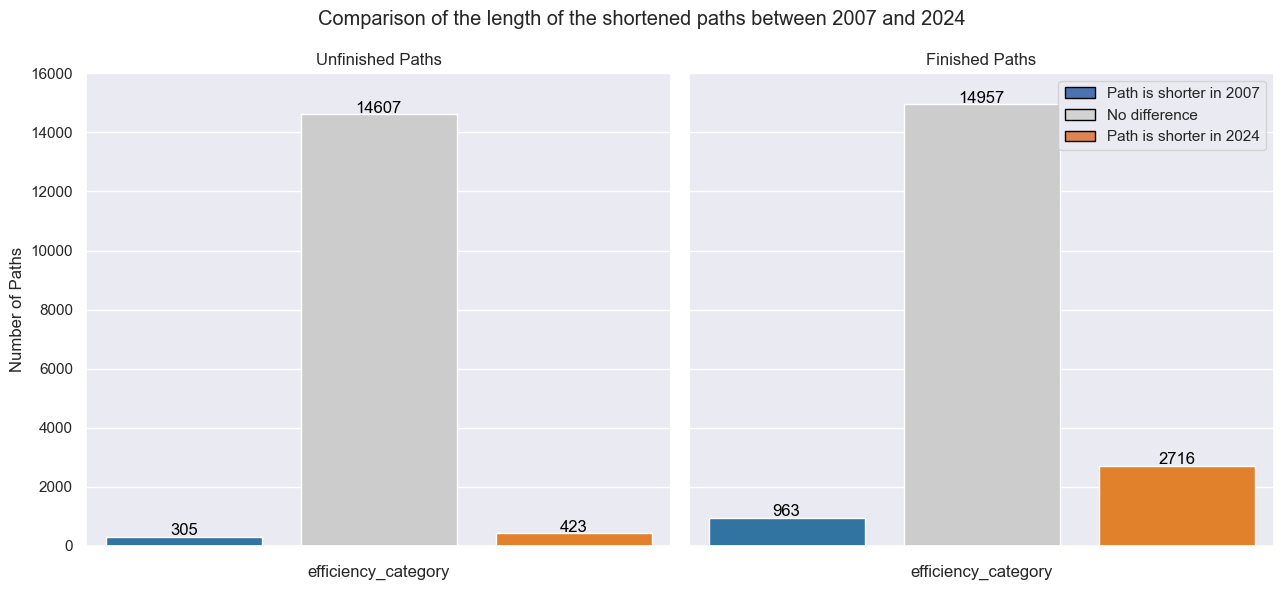

In [98]:
plot_comarison_length_path(df_finished2.copy(), df_unfinished2.copy())

Globally, we observe that for the most of the game player there is no difference in the number of game shortened between 2007 and 2024. But we can see that the 2024 version shortened more path than 2007 whether for unfinished and finished paths. This might suggests that the 2024 version has the potential to make players stronger ? That said, let's not jump to conclusions and take a closer look...

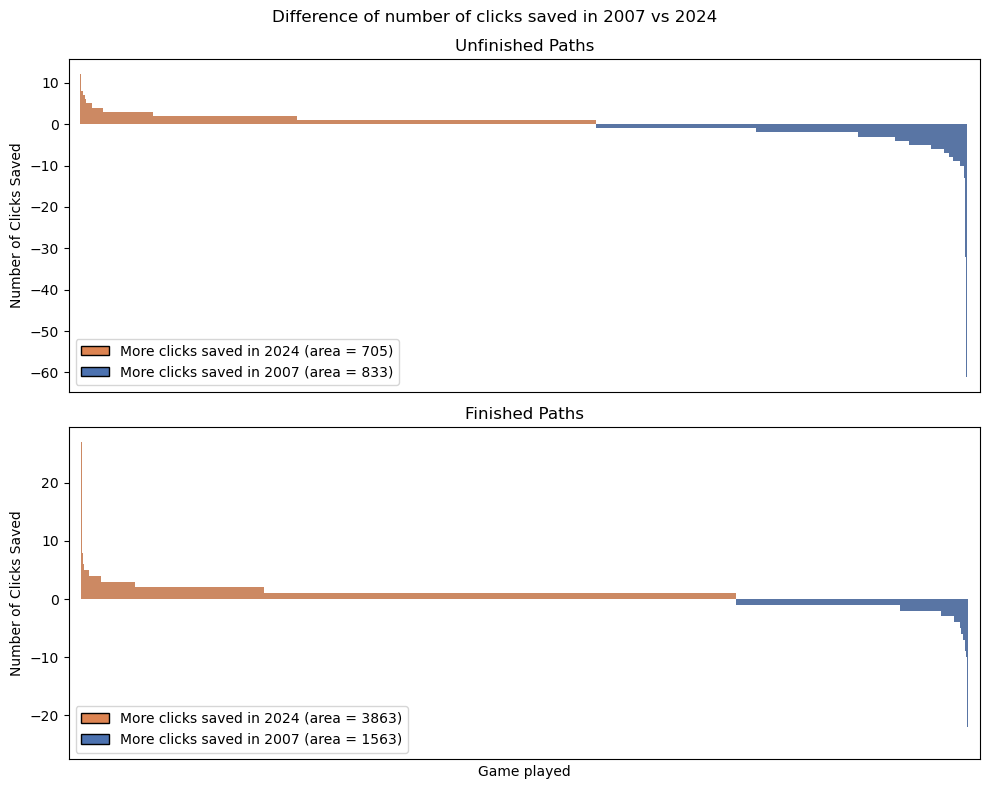

In [99]:
plot_comparison_clicks_saved(df_finished2.copy(), df_unfinished2.copy(), "Difference of number of clicks saved in 2007 vs 2024")

Looking at the number of clicks saved, it turns out 2007 does better for unfinished paths compared to 2024, even though it impacts fewer paths overall (305 paths for 833 clicks saved in 2007 versus 423 paths for 705 clicks saved in 2024).

On the other hand, for finished paths, 2024 clearly takes the lead, with 3,863 clicks saved across 2,716 paths, compared to just 1,000 clicks saved for 1,000 paths in 2007.

So, it seems like 2024 could potentially help players finish the game faster than 2007.

### Structural Comparison : 2007 vs. 2024

In [100]:
articles2007 = pd.read_csv(os.path.join(PATH_2007, 'articles.tsv'), sep='\t', comment='#', names=['article'])
articles2007_unquote = articles2007.copy()
articles2007_unquote['article'] = articles2007['article'].apply(unquote)

links2007_unquote = links2007.copy()
links2007_unquote['linkSource'] = links2007_unquote['linkSource'].apply(unquote)
links2007_unquote['linkTarget'] = links2007_unquote['linkTarget'].apply(unquote)

links2024_unquote = links2024.copy()
links2024_unquote['linkSource'] = links2024_unquote['linkSource'].apply(unquote)
links2024_unquote['linkTarget'] = links2024_unquote['linkTarget'].apply(unquote)

common_article = set(links2007_unquote['linkSource']).intersection(set(links2024_unquote['linkSource']))

In [101]:
# create a graph with links dataframe
G_2007 = nx.DiGraph()
G_2007.add_nodes_from(articles2007_unquote['article'])

for i, row in links2007_unquote.iterrows():
    if row['linkSource'] in G_2007.nodes and row['linkTarget'] in G_2007.nodes:
        G_2007.add_edge(row['linkSource'], row['linkTarget'])  

In [102]:
G_2024 = nx.DiGraph()
G_2024.add_nodes_from(articles2007_unquote['article'])

for i, row in links2024_unquote.iterrows():
    if row['linkSource'] in G_2024.nodes and row['linkTarget'] in G_2024.nodes:
        G_2024.add_edge(row['linkSource'], row['linkTarget'])

#### Similarity

How can we compare the efficiency of Wikipedia's structure in 2007 and 2024?

One approach is to evaluate the similarity between articles. For each article, we calculate its similarity with every other article. Then, we compute a similarity score for each article, which corresponds to the average similarity with all the articles it links to (outgoing links).

$$ \text{similarity score}(article) = \frac{1}{n} \sum_{i=1}^{n} \text{similarity}(article, article_i) $$

where $n$ is the number of outgoing links of the article, and $article_i$ is the $i$-th article linked to by the article.

How compute the similarity between two articles? 

The main task is to find a way to represent articles in a vector space. we decide to use two differents approaches:

- `Node2Vec`: We use the node2vec algorithm to compute the similarity between articles. Node2Vec is an algorithm that learns continuous feature representations for nodes in networks. We use the node2vec implementation from the `node2vec` library.

- `Sentence-BERT`: We use the Sentence-BERT model to represent article content in a vector space. Sentence-BERT is a modification of the BERT network that is trained to derive semantically meaningful sentence embeddings. We use the `sentence-transformers` library to compute the similarity between articles.

Node2vec focus more on the structure of the graph, while Sentence-BERT focus more on the content of the articles.

Then, our similarity score is the average of the similarity scores obtained with the two methods.

$$ \text{similarity}(a_1, a_2) = \frac{1}{2} \left( \text{similarity}(a_1, a_2)_{\text{Node2Vec}} + \text{similarity}(a_1, a_2)_{\text{Sentence-BERT}} \right) $$

where $a_1$ and $a_2$ are two articles.

First, we need to get the article content from wikipedia (only summary). 

- 2007 : We use the plaintext_articles data to get the content of the articles.

- 2024 : We use the Wikipedia API to get the content of the articles.

##### 2007

In [103]:
summaries2007 = get_summaries2007(ARTICLE_TXT_PATH, PATH_2007, 'summaries2007.csv')
summaries2007.head()

,article,content
0,Áedán_mac_Gabráin,Satellite image of northern Britain and Irelan...
1,Åland,Landskapet Åland\n Ahvenanmaan maakunta\n ...
2,Édouard_Manet,Articles with similar titles include Claude Mo...
3,Éire,This is a featured article. Click here for mor...
4,Óengus_I_of_the_Picts,Óengus son of Fergus\n King of the Picts\n ...


##### 2024

In [104]:
article_name_2024 = pd.read_csv(os.path.join(PATH_2024, 'articles2024_name.csv'), names=['article'])
summaries2024 = get_summaries2024(article_name_2024, PATH_2024, 'summaries2024.csv')
summaries2024.head()

,article,content
0,10th_century,The 10th century was the period from 901 (repr...
1,11th_century,The 11th century is the period from 1001 (repr...
2,12th_century,The 12th century is the period from 1101 to 12...
3,13th_century,The 13th century was the century which lasted ...
4,14th_century,The 14th century lasted from 1 January 1301 (r...


##### Node2Vec & Sentence-BERT to measure and compare structural similarities

In [105]:
links2007_similarity, links2024_similarity = get_links_similarity(DATA, PATH_2007, PATH_2024, ARTICLE_TXT_PATH, article_name_2024, 
                                                                  G_2007, G_2024, links2007_unquote, links2024_unquote, load=True)

links2007_similarity.head()

,linkSource,linkTarget,n2v_similarity,sbert_similarity,similarity
0,Áedán_mac_Gabráin,Bede,0.585006,0.237665,0.411335
1,Áedán_mac_Gabráin,Columba,0.731949,0.429983,0.580966
2,Áedán_mac_Gabráin,Dál_Riata,0.731973,0.650527,0.691250
3,Áedán_mac_Gabráin,Great_Britain,0.655600,0.170070,0.412835
4,Áedán_mac_Gabráin,Ireland,0.656894,0.342100,0.499497


In [106]:
links2024_similarity.head()

,linkSource,linkTarget,n2v_similarity,sbert_similarity,similarity
0,Áedán_mac_Gabráin,Dál_Riata,0.881055,0.550868,0.715962
1,Áedán_mac_Gabráin,Columba,0.760585,0.457233,0.608909
2,Áedán_mac_Gabráin,Orkney,0.744174,0.278360,0.511267
3,Áedán_mac_Gabráin,Isle_of_Man,0.568829,0.396943,0.482886
4,Áedán_mac_Gabráin,Bede,0.586326,0.274804,0.430565


In [107]:
similarity_2007 = links2007_similarity.groupby('linkSource')[['n2v_similarity', 'sbert_similarity']].mean()
similarity_2024 = links2024_similarity.groupby('linkSource')[['n2v_similarity', 'sbert_similarity']].mean()

similarities = pd.merge(similarity_2007, similarity_2024, on='linkSource', suffixes=('_2007', '_2024'))
similarities.describe()

,n2v_similarity_2007,sbert_similarity_2007,n2v_similarity_2024,sbert_similarity_2024
count,4539.000000,4539.000000,4539.000000,4539.000000
mean,0.539606,0.225459,0.565896,0.239078
std,0.120540,0.102761,0.122095,0.087992
min,0.234105,-0.133736,-0.024988,-0.095537
25%,0.450327,0.154362,0.479622,0.180471
50%,0.522074,0.215350,0.551837,0.237080
75%,0.617628,0.284711,0.640587,0.294082
max,0.991188,0.688811,0.947322,0.628260


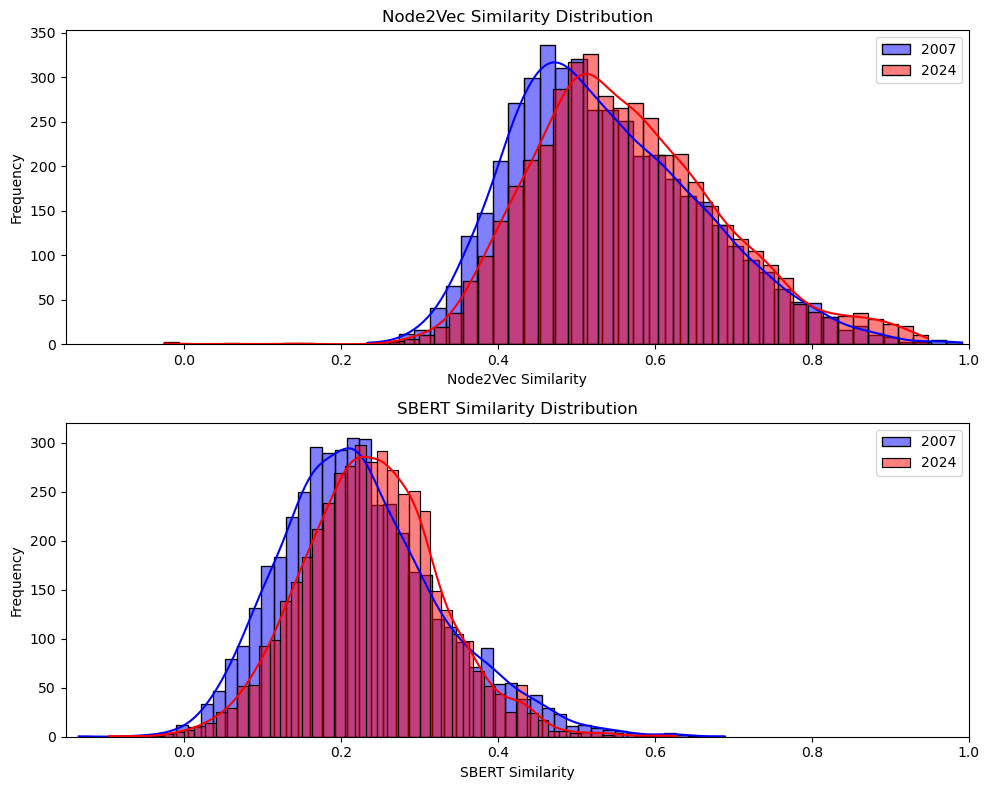

In [108]:
plot_similarity_distributions(similarities)

We can observe a slight improvement in the similarity for both structural and content-based similarity between articles in 2024 compared to 2007. The similarity between articles in 2024 is higher than in 2007, which indicates that the structure of Wikipedia has evolved to be more coherent and organized.

In [109]:
similarity_2007 = links2007_similarity.groupby('linkSource')['similarity'].mean()
similarity_2024 = links2024_similarity.groupby('linkSource')['similarity'].mean()

similarities = pd.merge(similarity_2007, similarity_2024, on='linkSource', suffixes=('_2007', '_2024'))
similarities.describe()

,similarity_2007,similarity_2024
count,4539.000000,4539.000000
mean,0.382532,0.402487
std,0.102174,0.094681
min,0.104964,-0.020964
25%,0.309238,0.337917
50%,0.367312,0.394595
75%,0.447471,0.458558
max,0.828664,0.752633


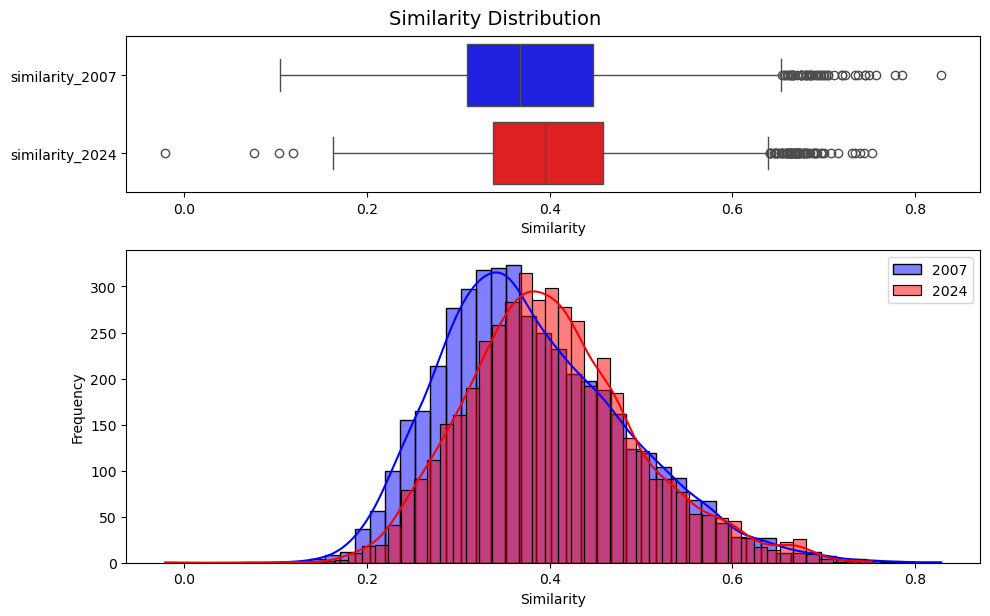

In [110]:
plot_similarity_distribution(similarities)

Again, we observe that the distribution of the combined similarity scores of articles in 2024 is slightly higher than in 2007. But is this difference significant? We perform a T-test to compare the two distributions. We choose a significance level of α=5%. Our null hypothesis is that the mean of both similarities distributions are equal. Our alternative hyppthesis is that the mean of the distribution of similarities in 2007 is smaller than iin 2020.

In [111]:
ttest_ind(similarities['similarity_2007'], similarities['similarity_2024'], alternative='less')

TtestResult(statistic=-9.651197194678133, pvalue=3.0957433459260986e-22, df=9076.0)

We obtain a p-value < 0.05. Thus, that provides very strong evidence that the mean of the distribution of similarities of 2007 is less than the mean of the distribution of similarities of 2024.

The evolution of Wikipedia’s structure from 2007 to 2024 has led to an improvement in the similarity between articles. The structure of Wikipedia in 2024 is more coherent and organized than in 2007.

## Part 4 : LLM performance on different versions


In this part of the notebook we will use games played by **mistral 7B** and **llama3 8B** in 2007 and 2024 to compare the evolution of the LLM over time.

We used [ollama](https://ollama.com/) docker container version to used LLMs models (see `SETUP.md` for installations instructions). for the prompt used to generate the games, we used the following prompt (inspired by the prompt used [Human vs IA](https://drudilorenzo.github.io/ada-klech-data-story/)):

First we give the context of the game to the llm:

>We now play the following game:\
\
I will give you a target word and a list from which you can choose an option. If the available options contains the target word, you choose it. Otherwise you choose the option that is most similar to it. Before starting, I give you one examples, then it's your turn:\
\
you need to follow the same format as the example below:
Target word: George_Washington\
\
Available options: [Able_Archer_83, Afghanistan, , Estonia, Europe, Finland, France, French_language, George_W._Bush, Hungary, September_11,_2001_attacks, United_States]\
\
Reasoning: I need to find something inside the list related to the target: 'George_Washington'. George Washington was the first president of United States and he lived in United States.\
\
Answer: Hence the answer is: 'United_States'.


Then we give the llm the target word and the list of options:

>I will give you a target word and a list from which you can choose an option. If the available options contains the target word, you choose it. Otherwise you choose the option that is most similar to it\
\
Target word: [{target}]\
\
Available options: [{links}]\
\
RESPECT THIS FORMAT WHEN ANSWERING:\
\
Reasoning: [REASONING]\
\
Answer: Hence the choice is: '[ANSWER]'


We will repeat this prompt with the new available options until the llm finds the target word or the prompt reaches 100 iterations.

Loading players games data on 2007 and LLMs (mistral, llama3) games data for 2007 and 2024


In [112]:
# Load data

## llama3 8B
llama3_2007 = pd.read_csv(DATA + "llama3/llm_paths.csv",index_col=['start', 'end'])
llama3_2024 = pd.read_csv(DATA + "llama3/llm_paths2024.csv",index_col=['start', 'end'])

## mistral 7B
mistral_2007 = pd.read_csv(DATA + "mistral/llm_paths.csv",index_col=['start', 'end'])
mistral_2024 = pd.read_csv(DATA + "mistral/llm_paths2024.csv",index_col=['start', 'end'])

## Player 2007
players_2007 = pd.read_csv(PATH_2007 + "/paths_finished.tsv",sep='\t', comment='#', names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating'])

## Path finished + unfinished
path_finished = pd.read_csv(PATH_2007 + "/paths_finished.tsv",sep='\t', comment='#', names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating'])
path_unfinished = pd.read_csv(PATH_2007 + "/paths_unfinished.tsv",sep='\t', comment='#', names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'target', 'type'])

In [113]:
players_2007 = process_player_path_data(players_2007)
by_path = combined_finished_unfinished(path_finished, path_unfinished)

### 4.1 LLMs parameters

We will select the games for the model to play based on how many times each game was attempted by the players, visualized using a CCDF plot. Additionally, we will determine the maximum number of prompts to give the model per game by analyzing the players’ path length distribution. Using the CCDF of the path length.

In [114]:
by_path_sorted = np.sort(by_path["count"])
by_path_n = len(by_path_sorted)
by_path_cdf = np.arange(1, by_path_n+1) / by_path_n
by_path_ccdf = 1 - by_path_cdf

path_lengt_sorted = np.sort(path_finished["length"])
path_lengt_n = len(path_lengt_sorted)
path_lengt_cdf = np.arange(1, path_lengt_n+1) / path_lengt_n
path_lengt_ccdf = 1 - path_lengt_cdf

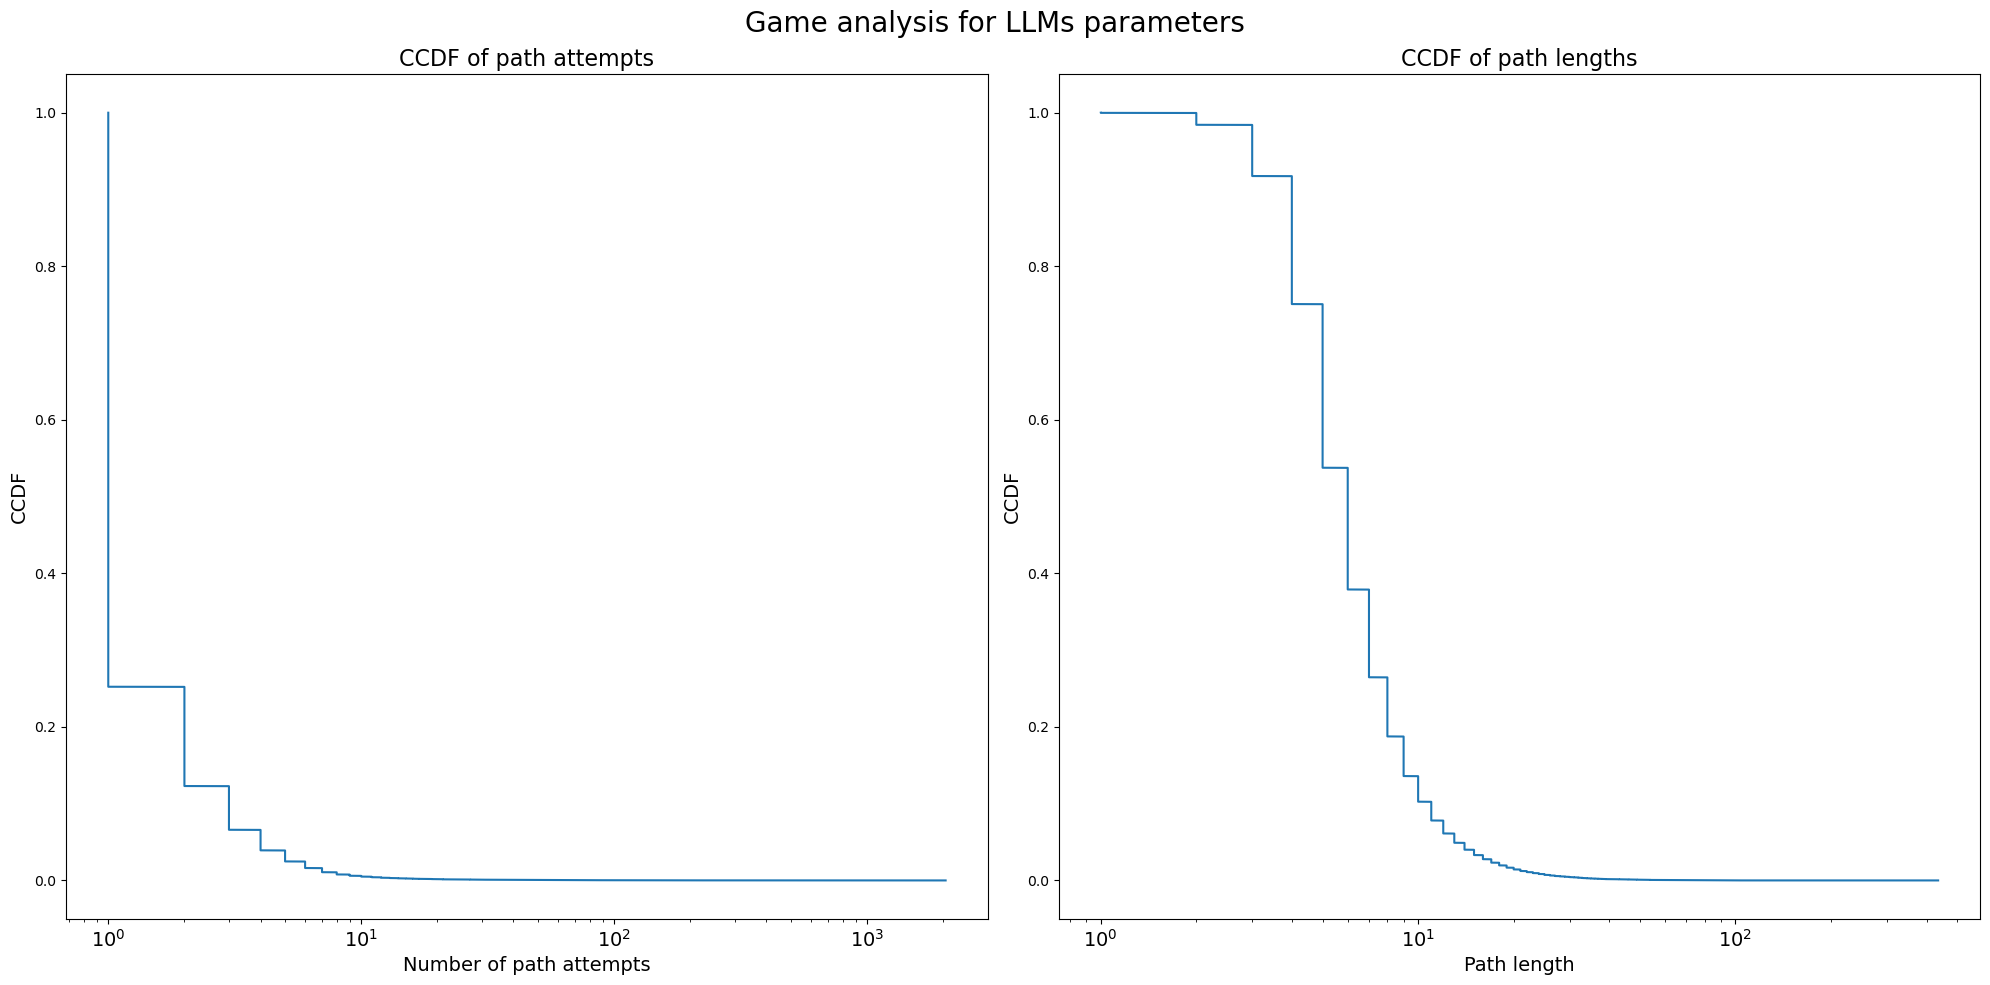

In [115]:
# plot distribution of path lengths
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Plot CCDF on the left
ax[0].plot(by_path_sorted, by_path_ccdf)
ax[0].set_xscale('log')
ax[0].set_xlabel('Number of path attempts', fontsize=14)
ax[0].set_ylabel('CCDF', fontsize=14)
ax[0].set_title('CCDF of path attempts', fontsize=16)
ax[0].xaxis.set_tick_params(labelsize=14)

# plot CCDF of path lengths
ax[1].plot(path_lengt_sorted, path_lengt_ccdf)
ax[1].set_xscale('log')
ax[1].set_xlabel('Path length', fontsize=14)
ax[1].set_ylabel('CCDF', fontsize=14)
ax[1].set_title('CCDF of path lengths', fontsize=16)
ax[1].xaxis.set_tick_params(labelsize=14)


plt.suptitle("Game analysis for LLMs parameters",fontsize=20)
plt.tight_layout()
plt.show()


From the CCDF, we observe that the number of attempts stops decreasing after 10, so we will focus on games that players have attempted more than 10 times. On the path length CCDF graph, the distribution seems to taper off around 30 clicks. However, we set the maximum number of clicks for the model to 50 to allow additional room for evaluation, particularly in cases where the model may perform less effectively and require more steps to complete the task.

### Compare LLMs with the players

The goal of this section is to compare the performance of the LLMs with the players in 2007 in order to see which LLMs seems to perform like the players in 2007.



In [116]:
## count null paths for all model
llama3_2007_null = llama3_2007["path"].isnull().sum()
llama3_2024_null = llama3_2024["path"].isnull().sum()
mistral_2007_null = mistral_2007["path"].isnull().sum()
mistral_2024_null = mistral_2024["path"].isnull().sum()

n_games = llama3_2007.shape[0]
total_games = llama3_2007.shape[0]

sns.set_theme(style="whitegrid")
null_paths = pd.DataFrame({ "model": ["llama3", "mistral"], "year": [2007, 2007,], "null_paths": [(total_games-llama3_2007_null)/total_games, (total_games-mistral_2007_null)/total_games]})

g = sns.catplot(x="year", y="null_paths", hue="model", data=null_paths, kind="bar", height=6, alpha=.6, palette="dark",errorbar="sd")
g.despine(left=True)
plt.ylim(0.88)
g.set_axis_labels("Year", "Frequency of paths found")
plt.title(f"Frequency of paths found by model among {n_games} games")

print(f"Difference in frequency of paths found between llama3 and mistral in 2007: {((total_games-llama3_2007_null)/total_games)-((total_games-mistral_2007_null)/total_games):.4f}")

Difference in frequency of paths found between llama3 and mistral in 2007: 0.0294


/opt/anaconda3/envs/outlier/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning:

The figure layout has changed to tight



We observe that llama3 finds 3% more paths than mistral.

Data processing :

- Remove the games that the llms did not finish
- Process path given by the llms by removing periodic loops, consecutive duplicates, cut the list to the first occurence of the target word.
- Compute the length of the path
- Compute basic statistics on the length of the path for each llm and player

In [117]:
# drop null paths
llama3_2007 = llama3_2007.dropna()
llama3_2024 = llama3_2024.dropna()
mistral_2007 = mistral_2007.dropna()
mistral_2024 = mistral_2024.dropna()

# transform path str(list) to list
llama3_2007["path"] = llama3_2007["path"].apply(lambda x: x[1:-1].replace("'", "").replace(" ", "").split(','))
llama3_2024["path"] = llama3_2024["path"].apply(lambda x: x[1:-1].replace("'", "").replace(" ", "").split(','))
mistral_2007["path"] = mistral_2007["path"].apply(lambda x: x[1:-1].replace("'", "").replace(" ", "").split(','))
mistral_2024["path"] = mistral_2024["path"].apply(lambda x: x[1:-1].replace("'", "").replace(" ", "").split(','))

In [118]:
# Post processing on paths 
llama3_2007["path"] = llama3_2007["path"].apply(post_processing)
llama3_2024["path"] = llama3_2024["path"].apply(post_processing)
mistral_2007["path"] = mistral_2007["path"].apply(post_processing)
mistral_2024["path"] = mistral_2024["path"].apply(post_processing)

In [119]:
llama3_2007["length"] = llama3_2007["path"].apply(len)
llama3_2024["length"] = llama3_2024["path"].apply(len)
mistral_2007["length"] = mistral_2007["path"].apply(len)
mistral_2024["length"] = mistral_2024["path"].apply(len)

In [120]:
# Compute the average length of the path for each model
avglen = pd.DataFrame(players_2007["length"].groupby(by=['start', 'end']).agg(['mean', 'std', 'median', 'count']))
avglen = pd.merge(avglen, llama3_2007['length'].groupby(by=['start','end']).agg(['mean', 'std', 'median', 'count']), left_index=True, right_index=True,suffixes=(None, '_llama3_2007'))
avglen = pd.merge(avglen, llama3_2024['length'].groupby(by=['start','end']).agg(['mean', 'std', 'median', 'count']), left_index=True, right_index=True,suffixes=(None, '_llama3_2024'))
avglen = pd.merge(avglen, mistral_2007['length'].groupby(by=['start','end']).agg(['mean', 'std', 'median', 'count']), left_index=True, right_index=True,suffixes=(None, '_mistral_2007'))

In [121]:
avglen.reset_index(inplace=True)

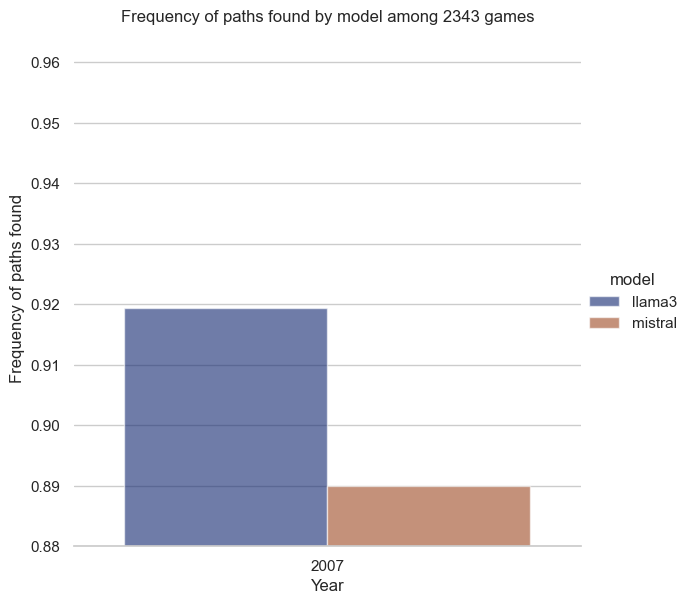

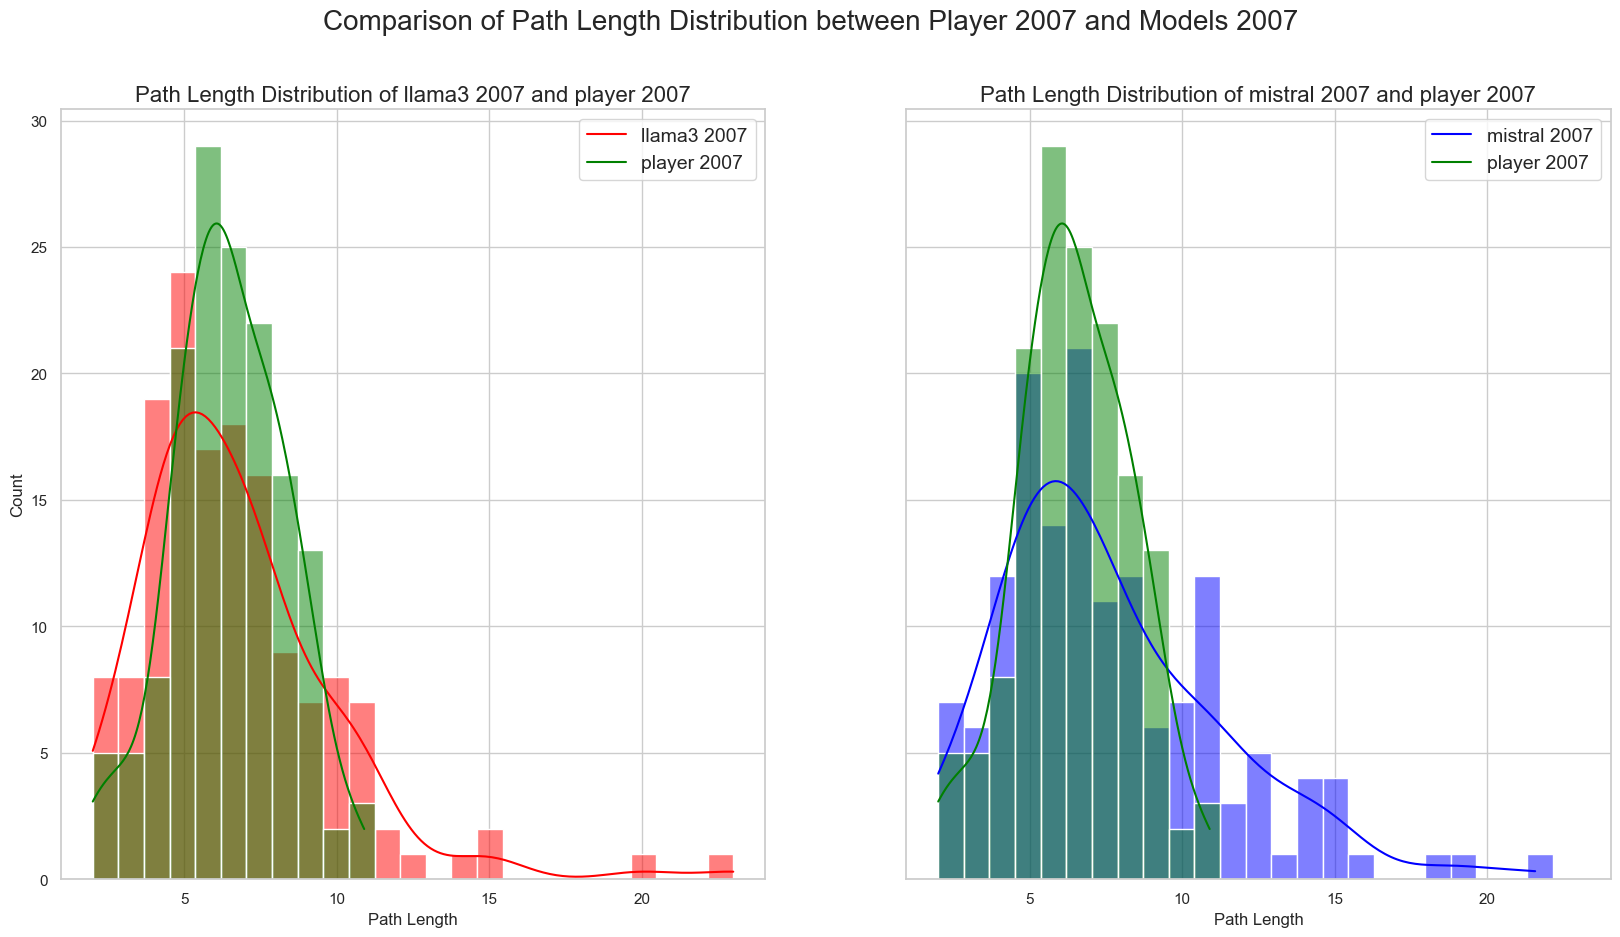

In [122]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharey=True)

# Define the bin edges
bins = np.histogram_bin_edges(avglen[['mean_llama3_2007', 'mean_mistral_2007', 'mean']], bins='auto')

# Plot for llama3 and player
sns.histplot(avglen['mean_llama3_2007'], kde=True, color='red', bins=bins, ax=axes[0])
sns.histplot(avglen['mean'], kde=True, color='green', bins=bins, ax=axes[0])
axes[0].legend(['llama3 2007', 'player 2007'],fontsize=14)
axes[0].set_xlabel('Path Length')
axes[0].set_ylabel('Count')
axes[0].set_title('Path Length Distribution of llama3 2007 and player 2007',fontsize=16)

# Plot for mistral and player
sns.histplot(avglen['mean_mistral_2007'], kde=True, color='blue', bins=bins, ax=axes[1])
sns.histplot(avglen['mean'], kde=True, color='green', bins=bins, ax=axes[1])
axes[1].legend(['mistral 2007', 'player 2007'],fontsize=14)
axes[1].set_xlabel('Path Length')
axes[1].set_title('Path Length Distribution of mistral 2007 and player 2007',fontsize=16)
plt.suptitle('Comparison of Path Length Distribution between Player 2007 and Models 2007',fontsize=20)
plt.show()

In [123]:
# t-test for the average path length of the player and the model
ttest_llama3 = ttest_ind(avglen['mean_llama3_2007'], avglen['mean'])
ttest_mistral = ttest_ind(avglen['mean_mistral_2007'], avglen['mean'])
print(f'T-Test between llama3 2007 and player: {ttest_llama3}')
print(f'T-Test between mistral 2007 and player: {ttest_mistral}')

T-Test between llama3 2007 and player: TtestResult(statistic=0.6474180983093178, pvalue=0.5178631742117132, df=296.0)
T-Test between mistral 2007 and player: TtestResult(statistic=3.427512979993781, pvalue=0.00069546543843258, df=296.0)


Llama3’s path length distribution visually aligns more closely with the players’ distribution compared to Mistral. To confirm this observation, we conducted a t-test with a significance level of α=5%. The results for Llama3 show a p-value of 0.52 and a statistic of 0.647, while for Mistral, the p-value is 0.0006 and the statistic is 3.428. Based on these findings, we fail to reject the null hypothesis for Llama3 but reject it for Mistral. This leads us to conclude that Llama3 better matches the players’ path length distribution than Mistral.

we will check whether the models’ average path length falls within the range defined by the players’ average path length plus or minus their standard deviation. For this, we will compare the path length averages of Llama3 and Mistral against the players’ range.

In [124]:
avglen['llama3_2007_in_CI'] = avglen.apply(lambda x: check_if_in_CI(x,'llama3_2007'), axis=1)
avglen["mistral_2007_in_CI"] = avglen.apply(lambda x: check_if_in_CI(x,'mistral_2007'), axis=1)
print(f'Number of LLM games in CI from player games: {avglen.llama3_2007_in_CI.mean()*100}%')
print(f'Number of Mistral games in CI from player games: {avglen.mistral_2007_in_CI.mean()*100}%')

# plot the number of games in CI
tmp_llama3 = avglen["llama3_2007_in_CI"].rename("in_CI").to_frame()
tmp_llama3["model"] = "llama3"
tmp_mistral = avglen["mistral_2007_in_CI"].rename("in_CI").to_frame()
tmp_mistral["model"] = "mistral"

ci_model = pd.concat([tmp_llama3, tmp_mistral])

sns.set_theme(style="whitegrid")
g = sns.catplot(x="model", y="in_CI", hue="model", data=ci_model, kind="bar", height=6, alpha=.6,errorbar=("ci", 95))
g.despine(left=True)
g.set_axis_labels("Model", "Percentage of games in CI (errorbar = CI 95%)")
plt.title("Percentage of games in CI from player games")

Number of LLM games in CI from player games: 78.52348993288591%
Number of Mistral games in CI from player games: 69.12751677852349%


/opt/anaconda3/envs/outlier/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning:

The figure layout has changed to tight



Text(0.5, 1.0, 'Percentage of games in CI from player games')

Llama3 falls within the players’ confidence interval in 78.5% of cases, compared to 69.1% for Mistral. This further supports the conclusion that Llama3 performs better than Mistral.

But does the model follow the same path as the players? To assess this, we can calculate the Jaccard similarity between the paths taken by the players and the models to check if they contain the same articles.

In [125]:
# compute jaccard similarity between player and model
players_2007 = players_2007["path"].apply(fix_player_path) # removing '<' in the path
jaccard_llama3 = pd.merge(players_2007, llama3_2007, on=['start', 'end'], suffixes=('_x', '_y'))
jaccard_llama3['jaccard'] = jaccard_llama3.apply(jaccard_similarity, axis=1)
print(f'Jaccard similarity between player and llama3 2007: {jaccard_llama3["jaccard"].mean()}')

jaccard_mistral = pd.merge(players_2007, mistral_2007, on=['start', 'end'], suffixes=('_x', '_y'))
jaccard_mistral['jaccard'] = jaccard_mistral.apply(jaccard_similarity, axis=1)
print(f'Jaccard similarity between player and mistral 2007: {jaccard_mistral["jaccard"].mean()}')

jaccard_llama3["LLM"] = "llama3"
jaccard_mistral["LLM"] = "mistral"

jaccard = pd.concat([jaccard_llama3, jaccard_mistral])
sns.set_theme(style="whitegrid")
g = sns.catplot(x="LLM", y="jaccard", hue="LLM", data=jaccard, kind="bar", height=6, alpha=.6,errorbar=("ci", 95))
g.set_axis_labels("LLM", "Jaccard similarity (errorbar = CI 95%)")
plt.title("Jaccard similarity between player and model")

Jaccard similarity between player and llama3 2007: 0.32247034792227663
Jaccard similarity between player and mistral 2007: 0.32934717100643923


/opt/anaconda3/envs/outlier/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning:

The figure layout has changed to tight



Text(0.5, 1.0, 'Jaccard similarity between player and model')

The Jaccard similarity reveals that both Llama3 and Mistral achieve slightly over 30% similarity with the players’ paths. This suggests that while their paths overlap with the players’ to some extent, most of the articles differ. Additionally, the similarity scores for the two models are so close that we cannot distinguish between their performances in this aspect.The jaccard similarity between the paths of the players in 2007 and llama3 is 0.27, which is quite low. This means that llama3 does not take similar paths to the players in 2007. the similarity with mistral is slightly higher with 0.32 but still low.


### Compare the results of the LLMs on 2007 and 2024

Based on the previous results, we choose to compare the results of llama3 on 2007 and 2024.



In [126]:
# plot not found paths
null_paths = pd.DataFrame({ "model": ["llama3", "llama3"], "year": [2007, 2024,], "null_paths": [(n_games-llama3_2007_null)/n_games, (n_games-llama3_2024_null)/n_games]})

g = sns.catplot(x="model", y="null_paths", hue="year", data=null_paths, kind="bar", height=6, alpha=.6, palette="dark",errorbar="sd")
g.despine(left=True)
g.set_axis_labels(None, "Frequency of paths found")
plt.ylim(0.88)
plt.title(f"Frequency of paths found between 2007 and 2024 among {n_games} games")
print(((n_games-llama3_2007_null)/n_games)-((n_games-llama3_2024_null)/n_games))

-0.03713188220230479


/opt/anaconda3/envs/outlier/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning:

The figure layout has changed to tight



We observe that in 2024, Llama3 discovers 4% more paths compared to 2007. However, does Llama3 in 2024 exhibit a better path length distribution than it did in 2007?

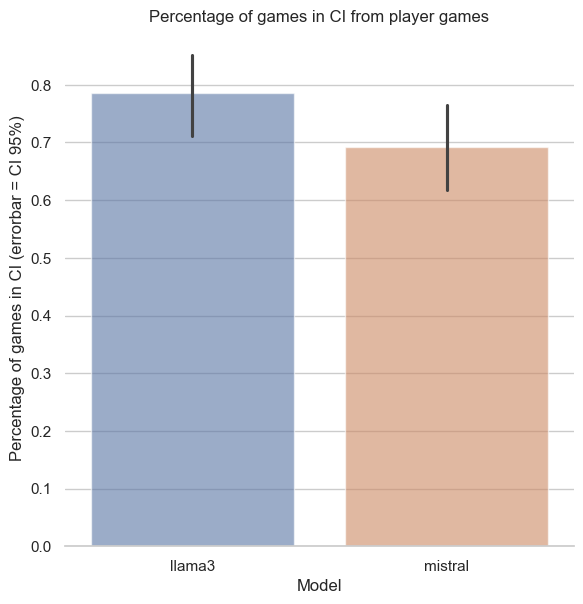

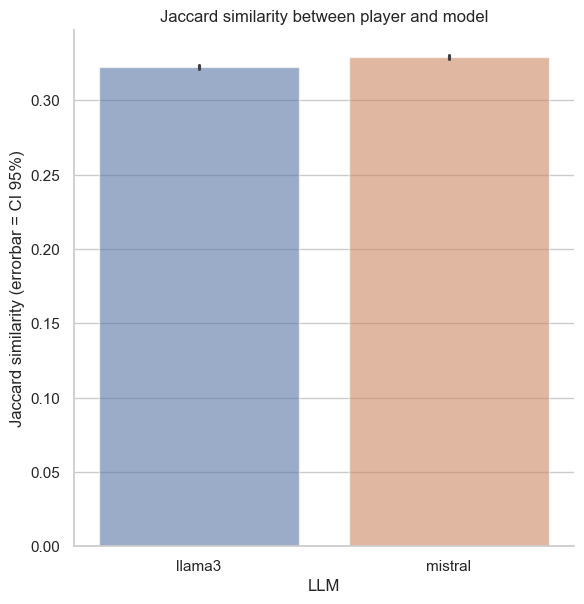

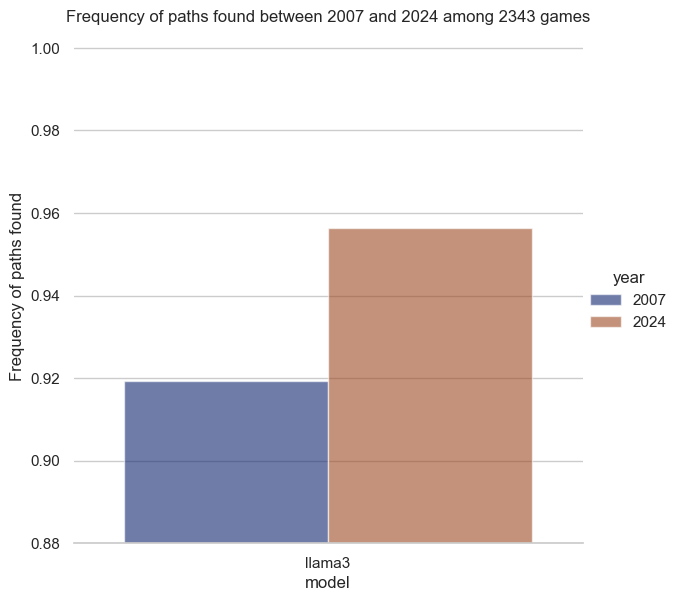

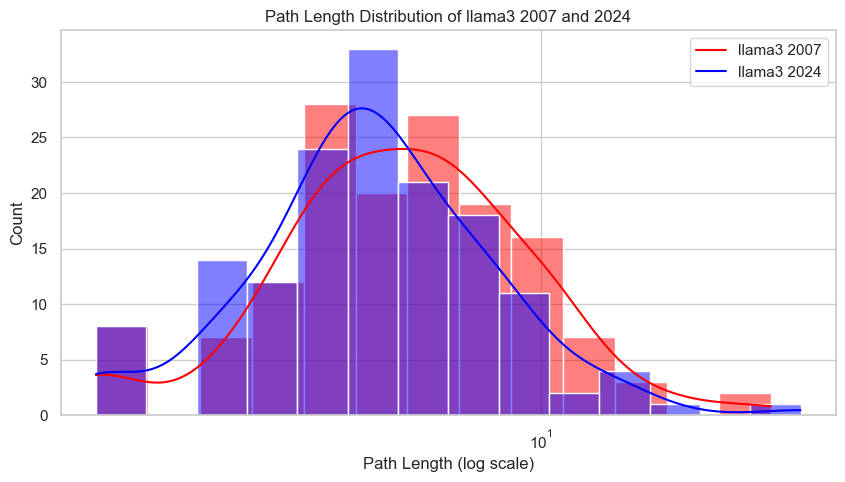

In [127]:
# plot path length distribution of llama3 2007 and 2024
plot_path_length_distribution(avglen, 'llama3',log_scale=True)

In [128]:
# T-test between llama3 2007 and 2024
ttest_llama3 = ttest_ind(avglen['mean_llama3_2024'],avglen['mean_llama3_2007'],alternative='less')
print(f'T-Test between llama3 2007 and 2024: {ttest_llama3}')


T-Test between llama3 2007 and 2024: TtestResult(statistic=-1.993857325739498, pvalue=0.023542484821464305, df=296.0)


We observe that Llama3 in 2024 exhibits a better path length distribution compared to 2007. To validate this observation, we performed a t-test with an alternative hypothesis that the path length distribution in 2024 is less than in 2007 (2024 < 2007). Using a significance level of alpha=5
%, the test yielded a p-value of 0.023 and a statistic of −1.99. Since the p-value is below the significance level, we reject the null hypothesis and conclude that Llama3 in 2024 has a better path length distribution than in 2007.


In conclusion, we can state that Llama3’s performance has improved between 2007 and 2024, reflecting advancements in LLM capabilities. Theoretically, players in 2024 should also perform better than players in 2007, likely reaching the target page in fewer clicks.

# Conclusion 

Wikipedia is one of the most important collaborative database freely accessible on internet, and is the most-read reference work in history. Thanks to its highly dynamic nature, it keeps expanding and reorganizes itself everyday to improve its knowledge. Our analysis provides an insight into how Wikipedia has evolved between 2007 and 2024 in the specific context of the game Wikispeedia. We were interested in knowing if the game would be easier in 2024 compared to 2007. 

Through our project, we thus analyzed the performance of layers on articles from 2007 to gain insight on which factors could impact game success and see how that would apply to 2024 later on. We discovered that articles are not evenly distributed among categories and that the categories of the articles affect the success of the game. We also saw that as the shortest path increases between two articles it would impact negatively the success rate of games. The most important factor to predict the difficulty of a game played was identified to be the number of articles redirecting to the target article. 

In a second time we compared the structure of Wikipedia in 2007 compared to its structure in 2024. Many articles changed names between the two years, and became referred to with more specific and specialized names in 2024. The total number and average of links drastically increased in 2024, while the shortest path on average decreased. Comparing the overall networks' shapes, they share many similarities but can be distinguished by looking at the most 'important' articles in the pagerank sense, meaning the central hubs and their repartition do differ between the two. We saw that the clustering is also higher in 2024 while having a better connectivity. 

To understand how the differences that we found in 2024 could have impacted the paths played in 2007, we saw the target article would appear sooner in the paths in 2007 compared to 2024. The structural differences of the two networks also provided interesting information : the similarity of the 2024 articles in the textual contents and the graph structure is better and may reflect a more intuitive way of naviguating throught the pages which leads us to think that the game would be easier in play in 2024 compared to 2007.

Finally, as a final proof to our analysis, as we do not have the data of players playing Wikispeedia in 2024 we tested LLMs on the two data to see if our previous observations would be verified by it. We trained 2 different models on 2007 and selected one of them to play also on 2024. We found that the LLM performed better on 2024 with a higher number of games won and a shorter path on average. 
To conclude, even though it may be hard to infer that the 2024 Wikispeedia game would be truly easier, we collected pretty good evidence that leads us towards this direction. The ideal proof would be to actually collect players' performance on a 2024 version of the game but our analysis still provides an interesting insight on the question.

# References


[1] Robert West and Jure Leskovec:
     Human Wayfinding in Information Networks.
     21st International World Wide Web Conference (WWW), 2012.
     
[2] Robert West, Joelle Pineau, and Doina Precup:
     Wikispeedia: An Online Game for Inferring Semantic Distances between Concepts.
     21st International Joint Conference on Artificial Intelligence (IJCAI), 2009.